# Model I: XGBoost

XGBoost is trained using reg:squared. 

XGBoost has hyper parameter tuning by minimizing a metric that is closer to interpretale by humans. 


In [1]:
import warnings
warnings.filterwarnings("ignore")

from datetime import timedelta, datetime
import itertools
import json
import matplotlib.pyplot as plt
from matplotlib import rcParams
import mlflow
import numpy as np
import os
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
import yaml
from tqdm import tqdm 
import mlflow
from time import time
import pickle
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, plotting, space_eval

# Get the current project path (where you open the notebook)
# and go up two levels to get the project path
current_dir = Path.cwd()
proj_path = current_dir.parent.parent

# make the code in src available to import in this notebook
import sys
sys.path.append(os.path.join(proj_path, 'src'))

import xgboost as xgb
from xgboost import XGBClassifier

from metrics import *
from utils import *


# Catalog contains all the paths related to datasets
with open(os.path.join(proj_path, 'conf/catalog.yml'), "r") as f:
    catalog = yaml.safe_load(f)['olist']
    
# Params contains all of the dataset creation parameters and model parameters
with open(os.path.join(proj_path, 'conf/params.yml'), "r") as f:
    params = yaml.safe_load(f)
    

In [2]:
space = {
        # Range passed for learning rate
       'eta': hp.quniform('eta', 0.02, 0.5, 0.01),
        # Control overfitting
        # Maximum depth of a tree: default 6 -> range: [0:∞]
        'max_depth':  hp.choice('max_depth', np.arange(2, 10, dtype=int)),
        # Minimum sum of instance weight (hessian) needed in a child: default 1
        'min_child_weight': hp.quniform('min_child_weight', 1, 3, 1),
        # Add randomness to make training robust to noise (control overfitting)
        # Subsample ratio of the training instance: default 1
        'subsample': hp.quniform('subsample', 0.2, 1, 0.1),
        # Subsample ratio of columns when constructing each tree: default 1
        'colsample_bytree': hp.quniform('colsample_bytree', 0.2, 1, 0.1),
        'n_estimators': hp.choice('n_estimators', np.arange(5, 150, dtype=int))
        }

#Search function that will return the parameter values for the optimized score
def optimize():
       
    # tpe.suggest is the algorithm used for updating the search space
    # trials are used to log the information
    # max_evals is used to specify how many combinations to look for

    best = fmin(_score, space, algo=tpe.suggest, trials=trials, max_evals=params['xgb']['search_iter'], verbose=0)
   
    return best

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Processing product category: bed_bath_table
  - - Processing range 2017-01-01 to 2018-01-28
  - - Processing range 2017-01-29 to 2018-02-25
  - - Processing range 2017-02-26 to 2018-03-25
  - - Processing range 2017-03-26 to 2018-04-22
  - - Processing range 2017-04-23 to 2018-05-20
  - - Processing range 2017-05-21 to 2018-06-17
  - - Processing range 2017-06-18 to 2018-07-15
  - - Processing range 2017-07-16 to 2018-08-12


2020/12/11 11:16:57 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



Processing product category: health_beauty
  - - Processing range 2017-01-01 to 2018-01-28
  - - Processing range 2017-01-29 to 2018-02-25
  - - Processing range 2017-02-26 to 2018-03-25
  - - Processing range 2017-03-26 to 2018-04-22
  - - Processing range 2017-04-23 to 2018-05-20
  - - Processing range 2017-05-21 to 2018-06-17
  - - Processing range 2017-06-18 to 2018-07-15
  - - Processing range 2017-07-16 to 2018-08-12
Processing product category: sports_leisure
  - - Processing range 2017-01-01 to 2018-01-28
  - - Processing range 2017-01-29 to 2018-02-25
  - - Processing range 2017-02-26 to 2018-03-25
  - - Processing range 2017-03-26 to 2018-04-22
  - - Processing range 2017-04-23 to 2018-05-20
  - - Processing range 2017-05-21 to 2018-06-17
  - - Processing range 2017-06-18 to 2018-07-15
  - - Processing range 2017-07-16 to 2018-08-12
Processing product category: furniture_decor
  - - Processing range 2017-01-01 to 2018-01-28
  - - Processing range 2017-01-29 to 2018-02-25
  - 

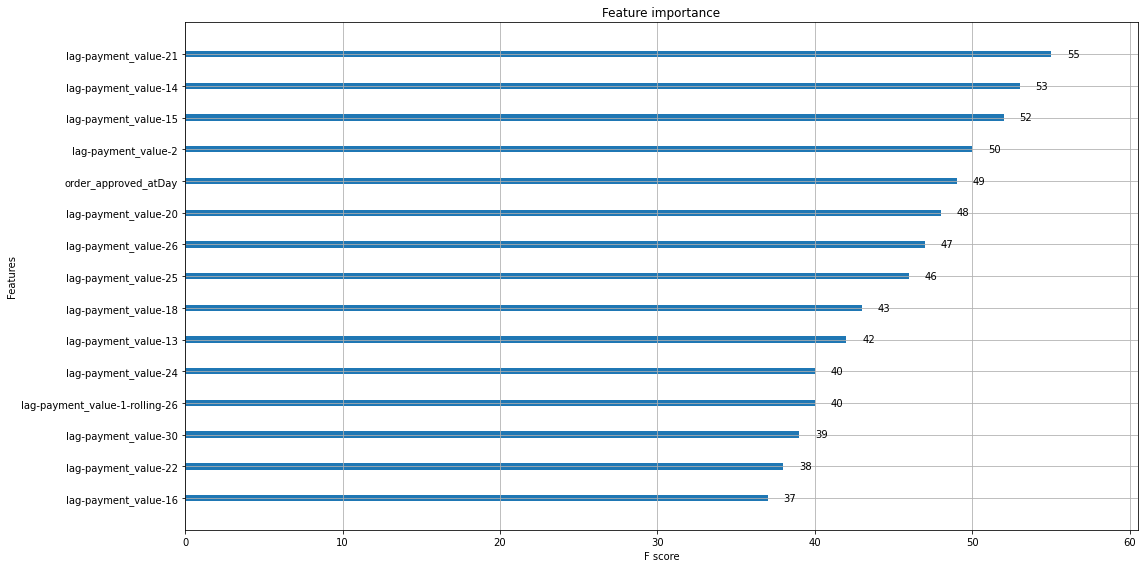

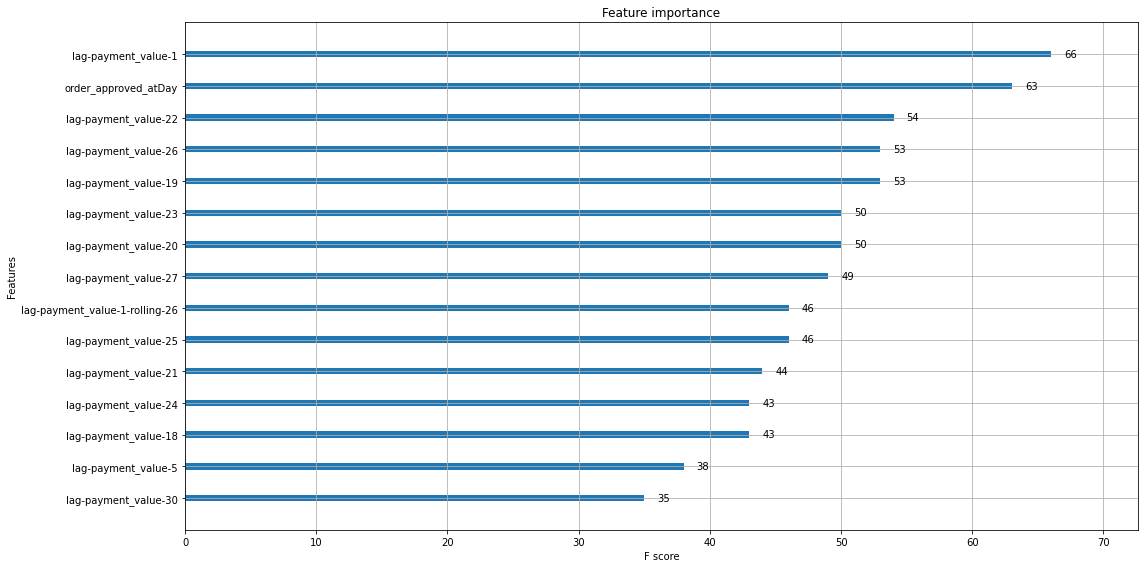

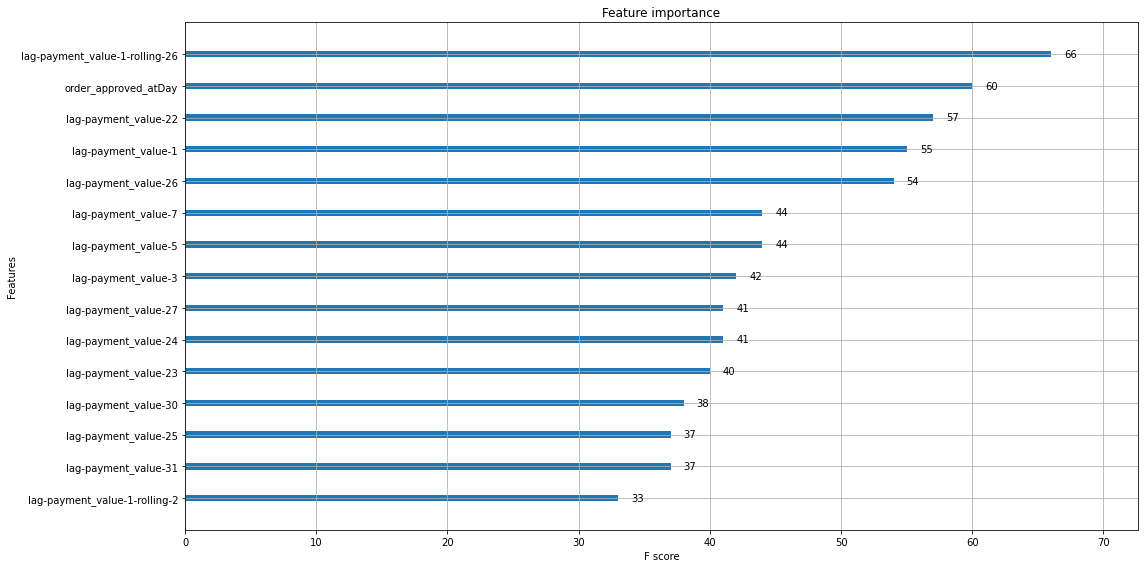

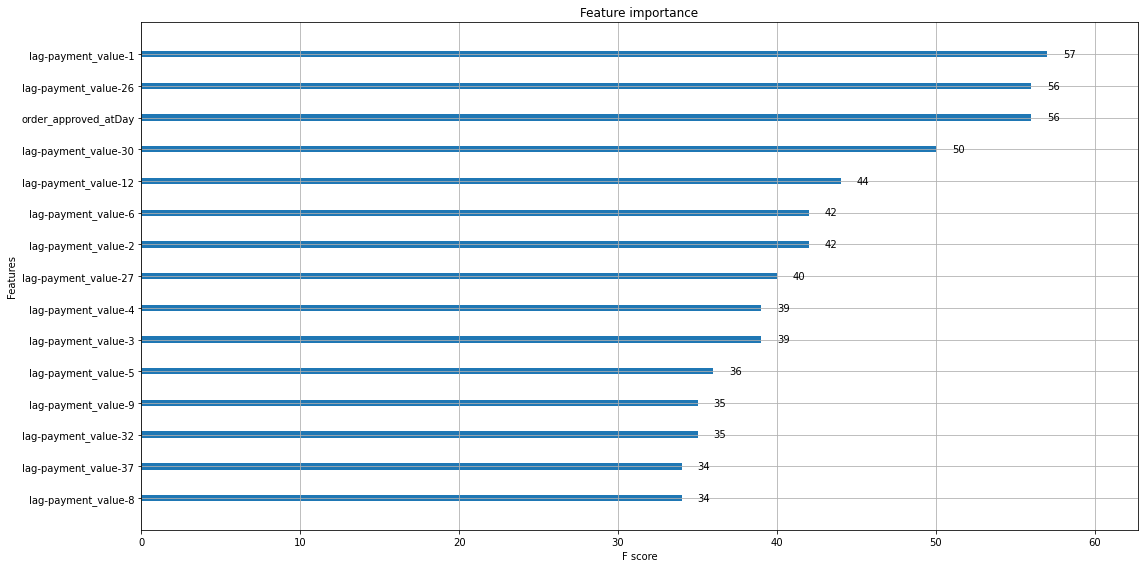

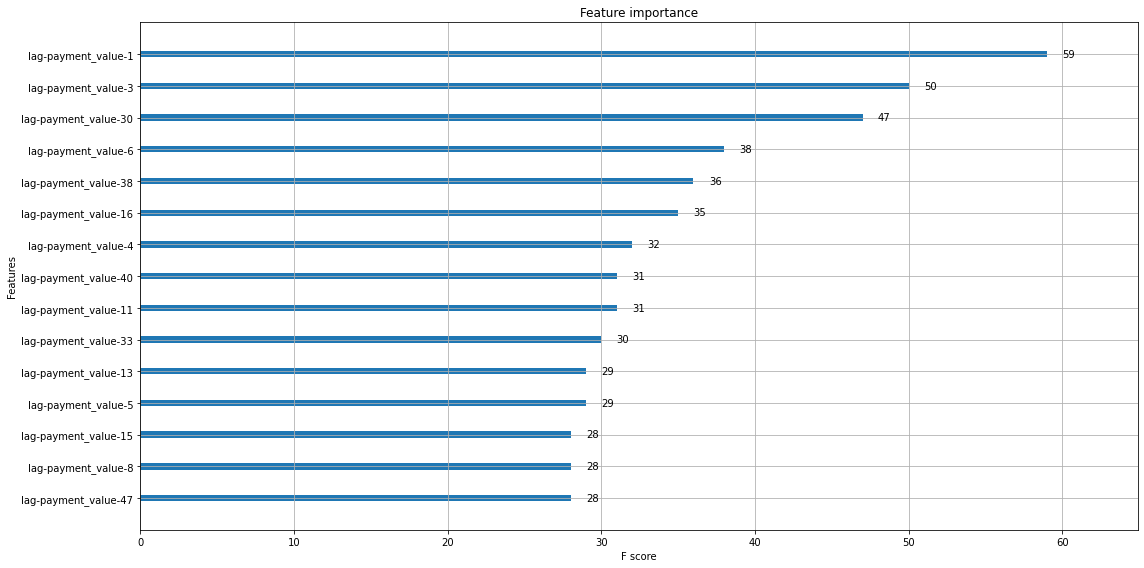

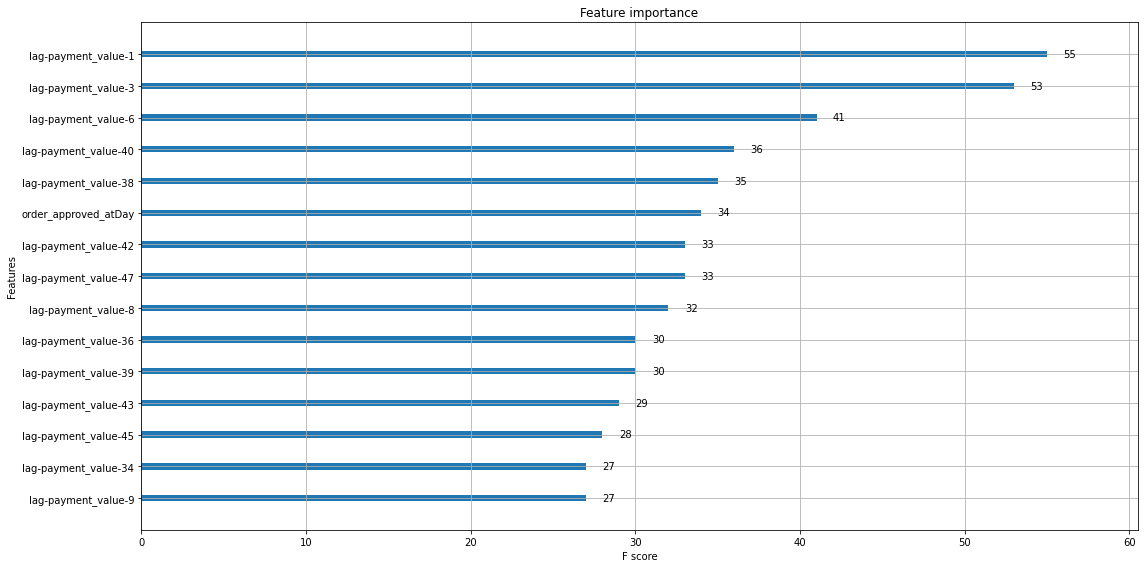

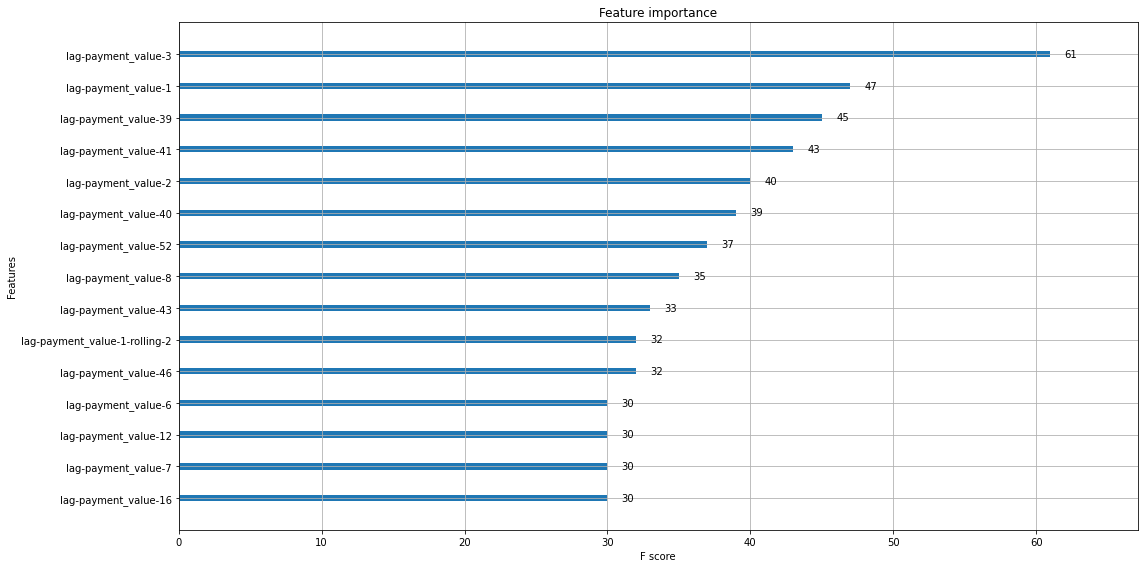

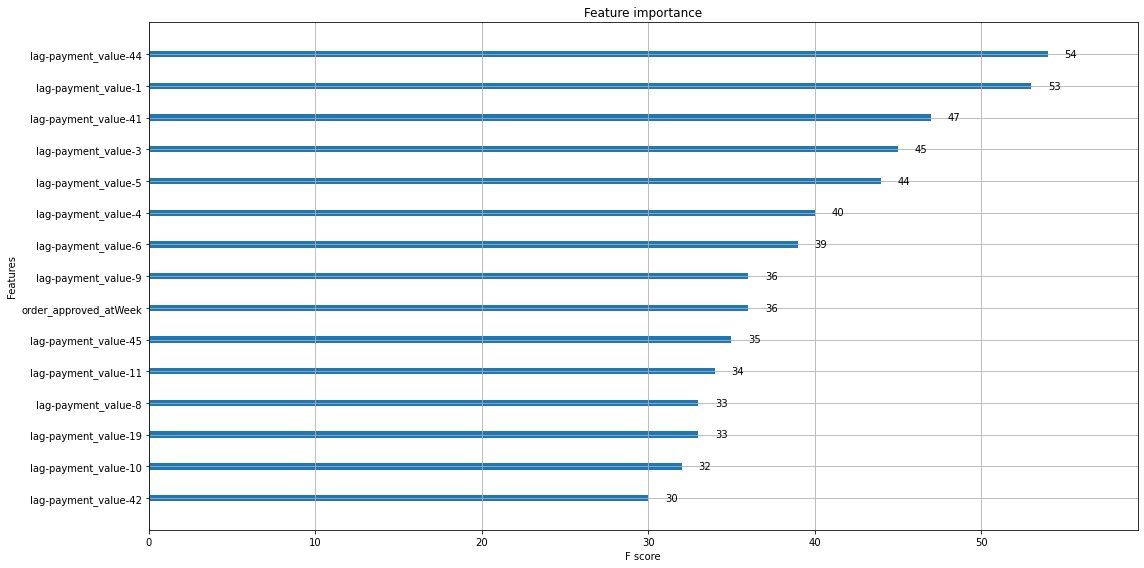

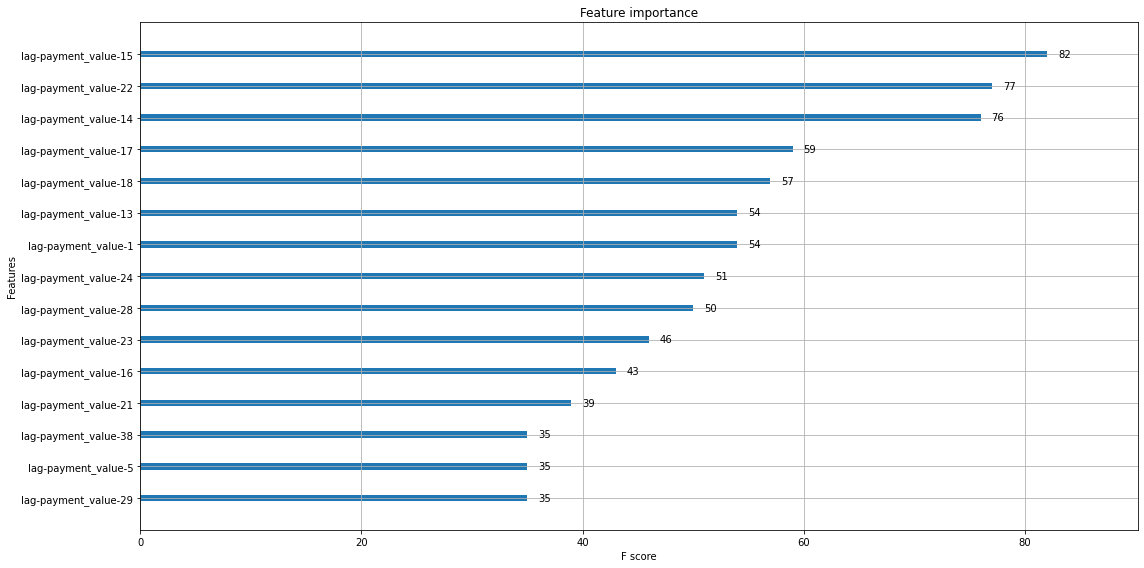

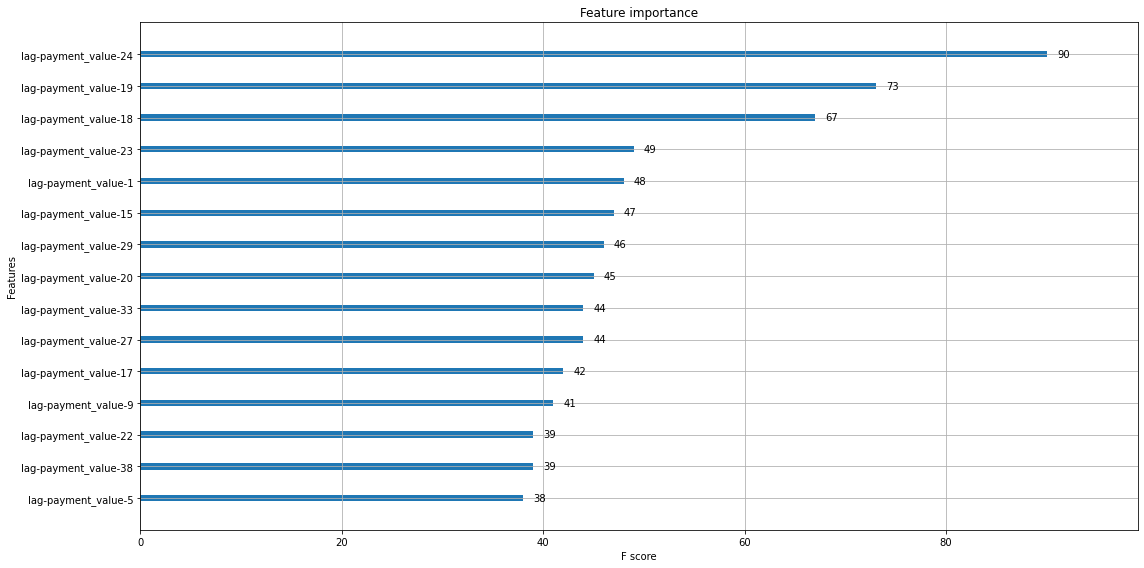

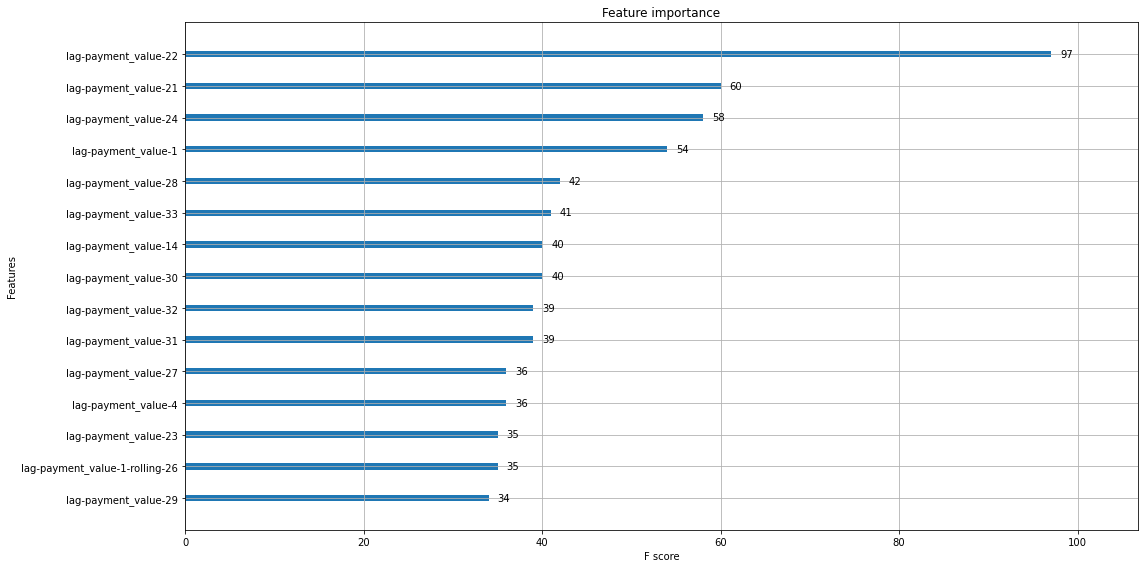

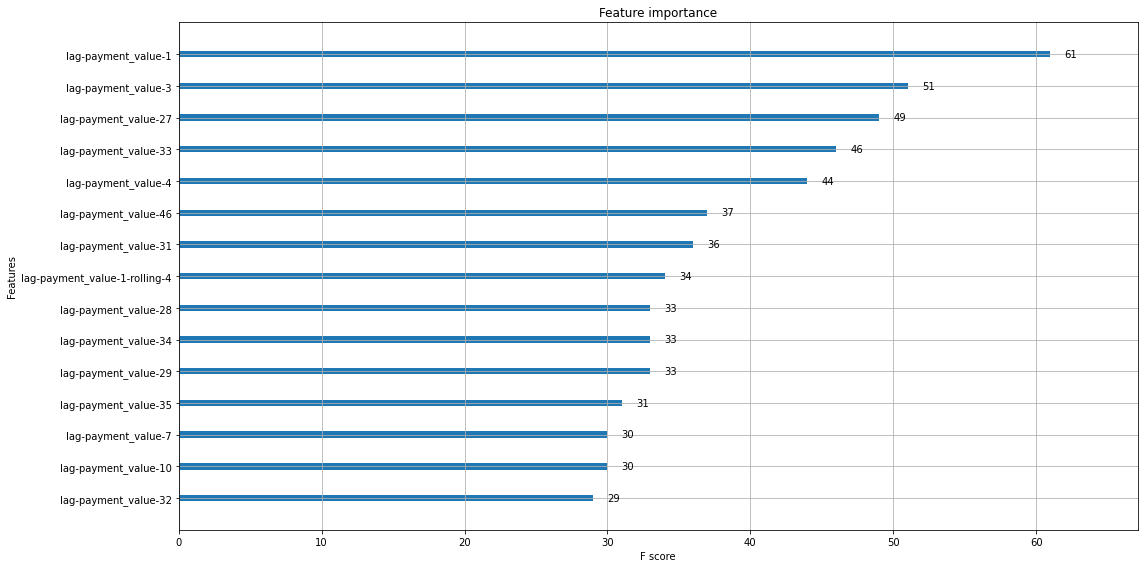

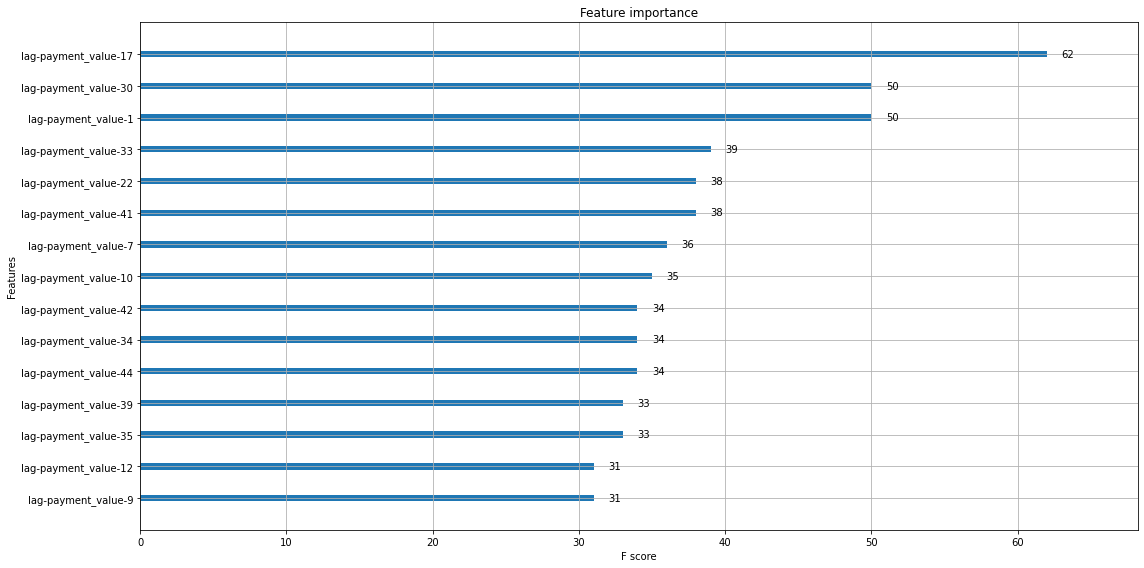

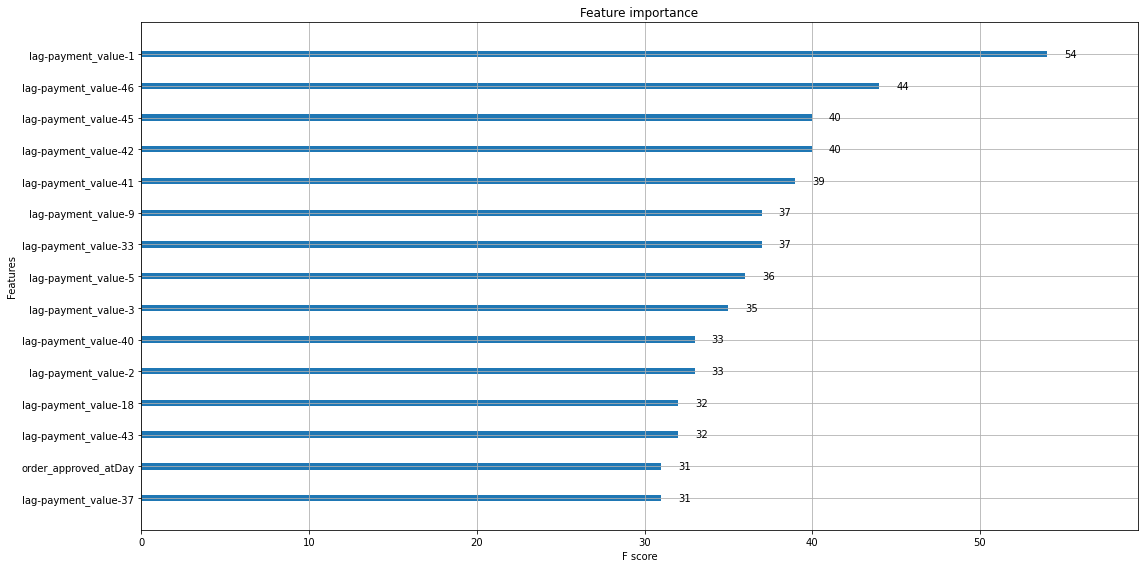

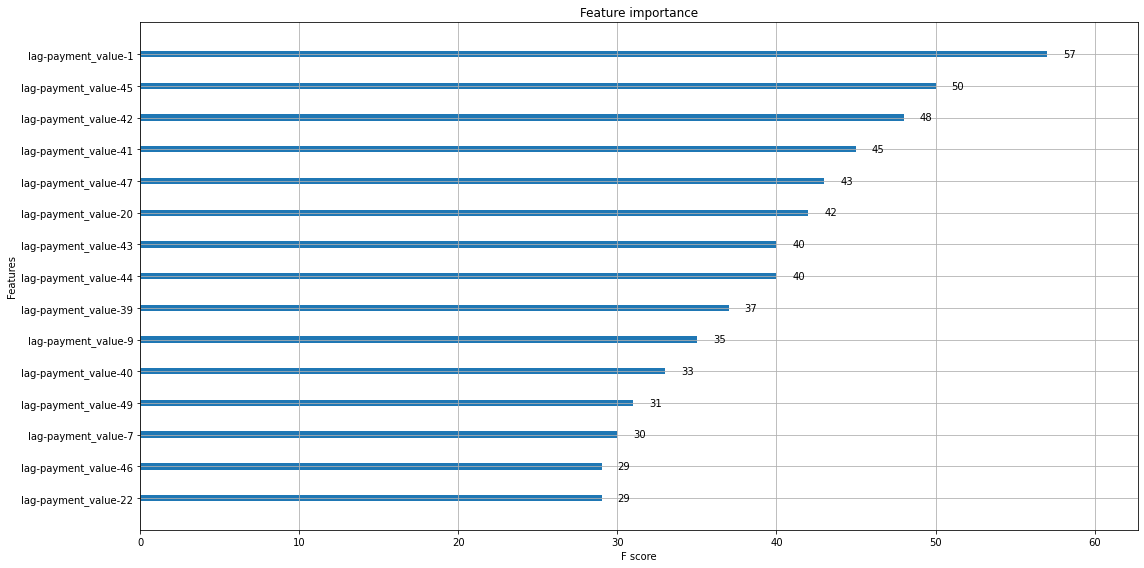

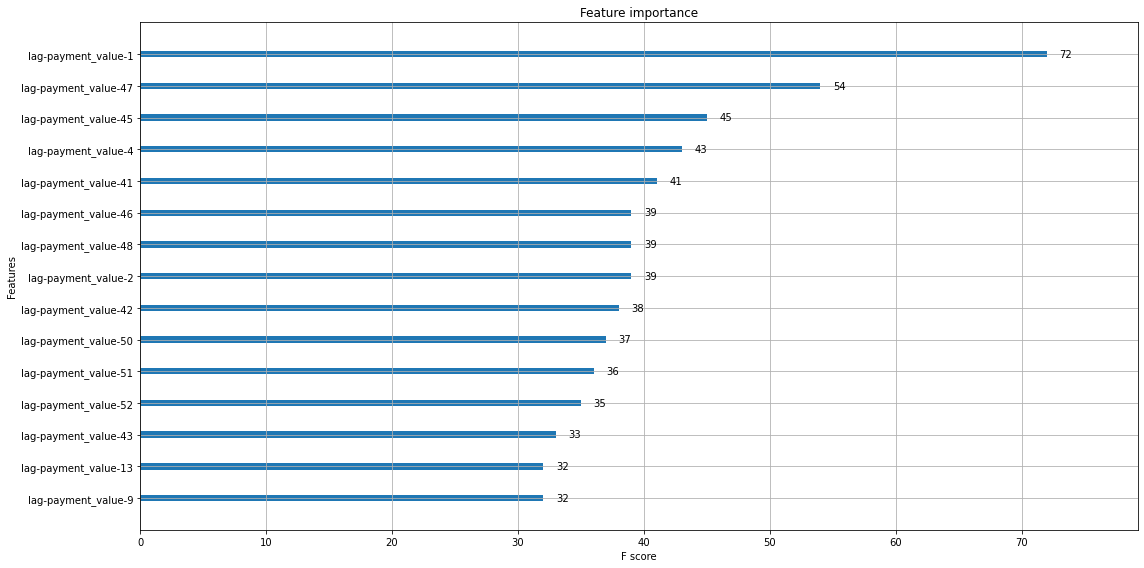

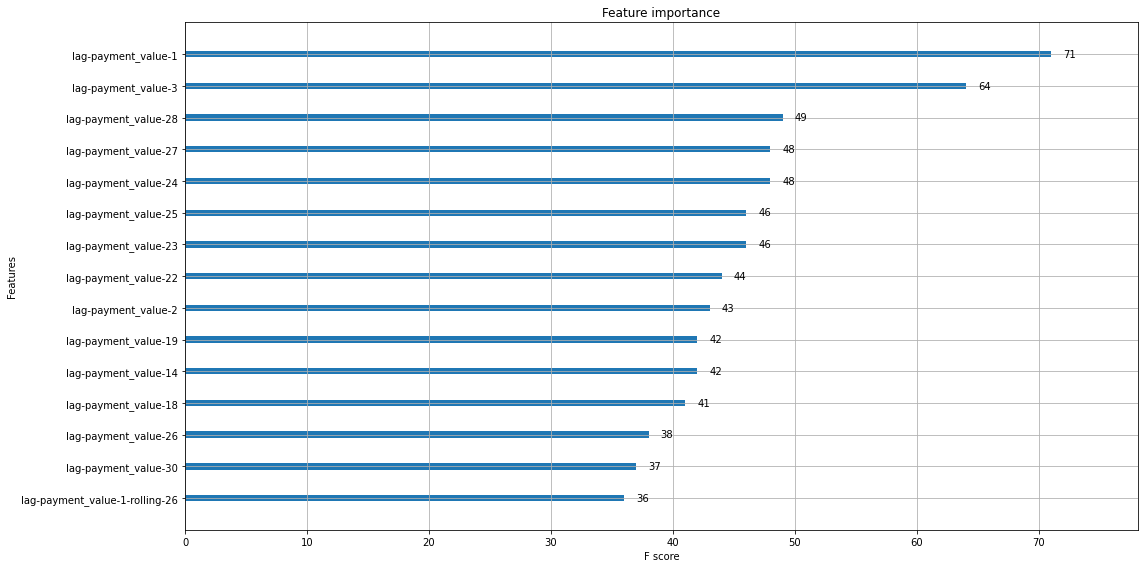

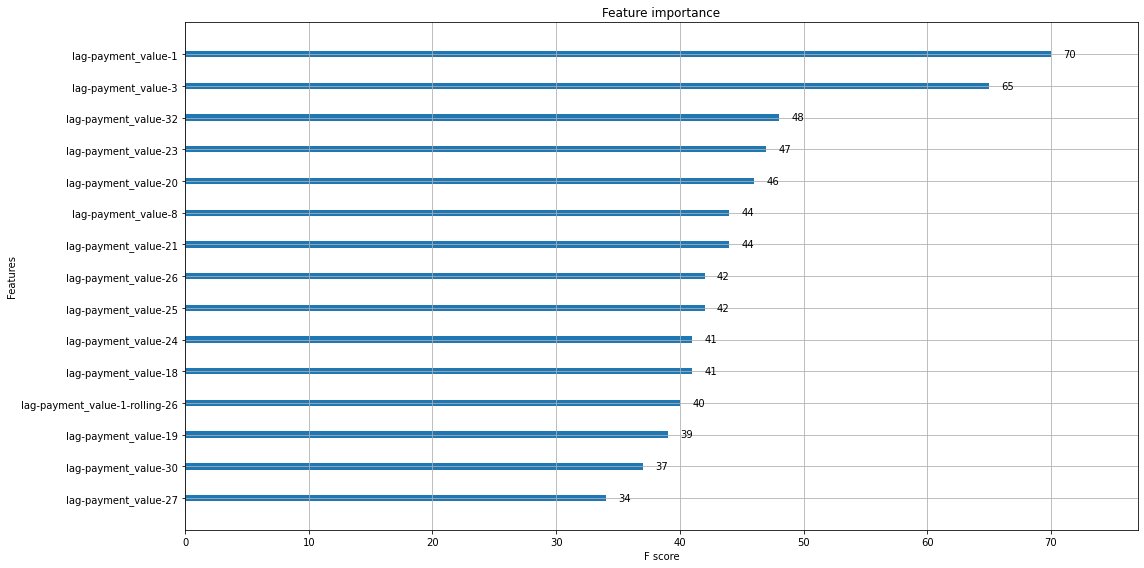

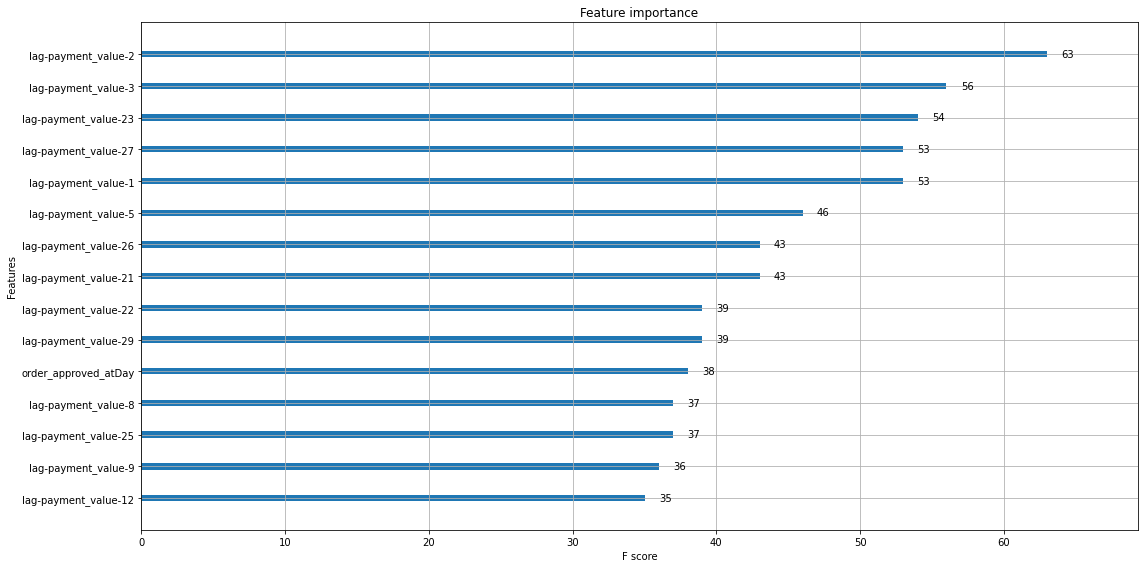

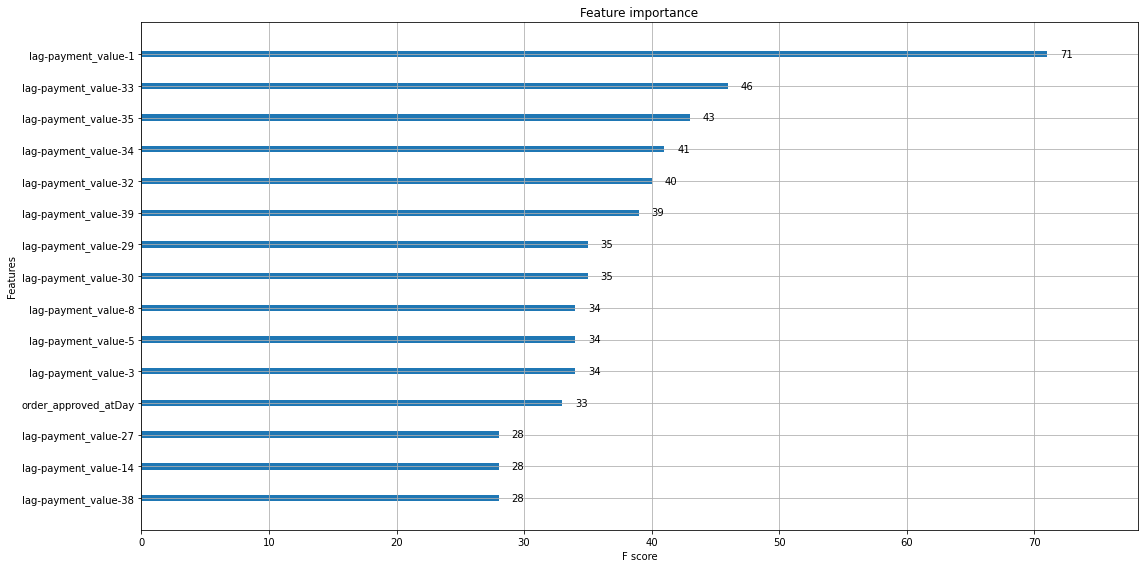

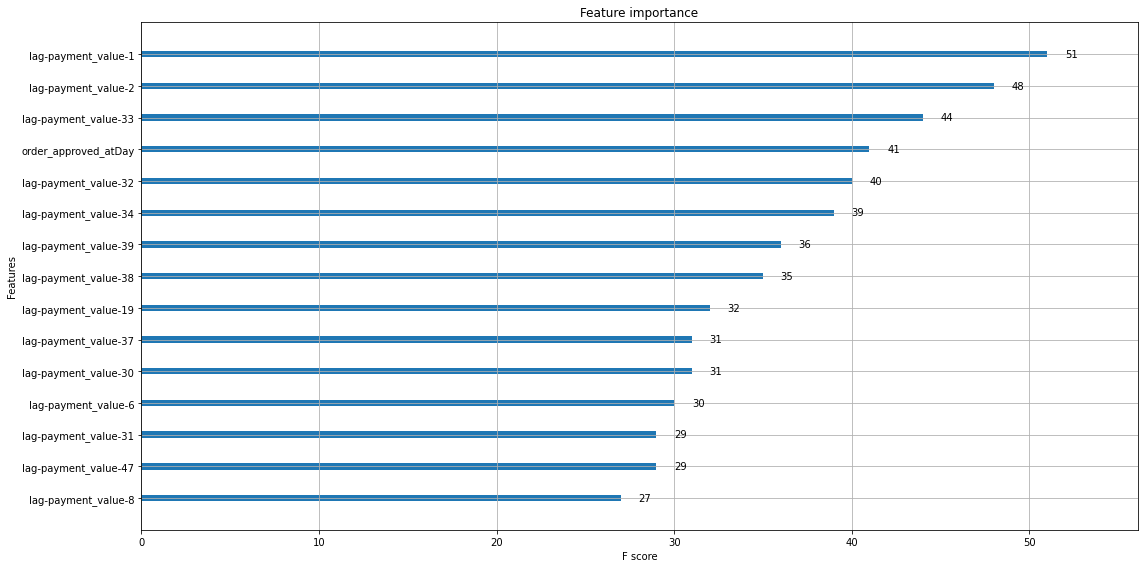

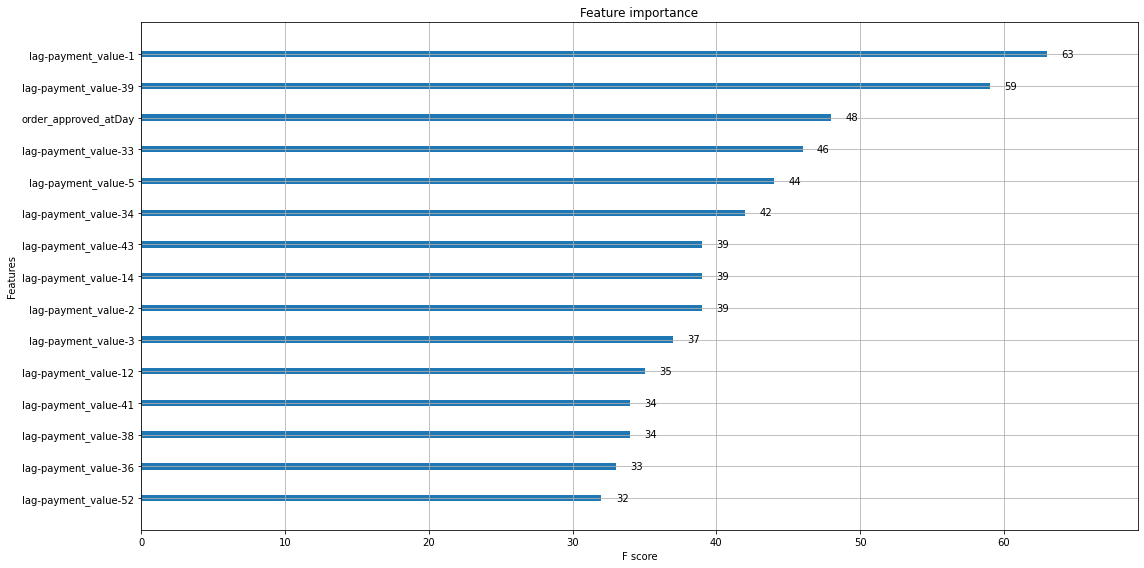

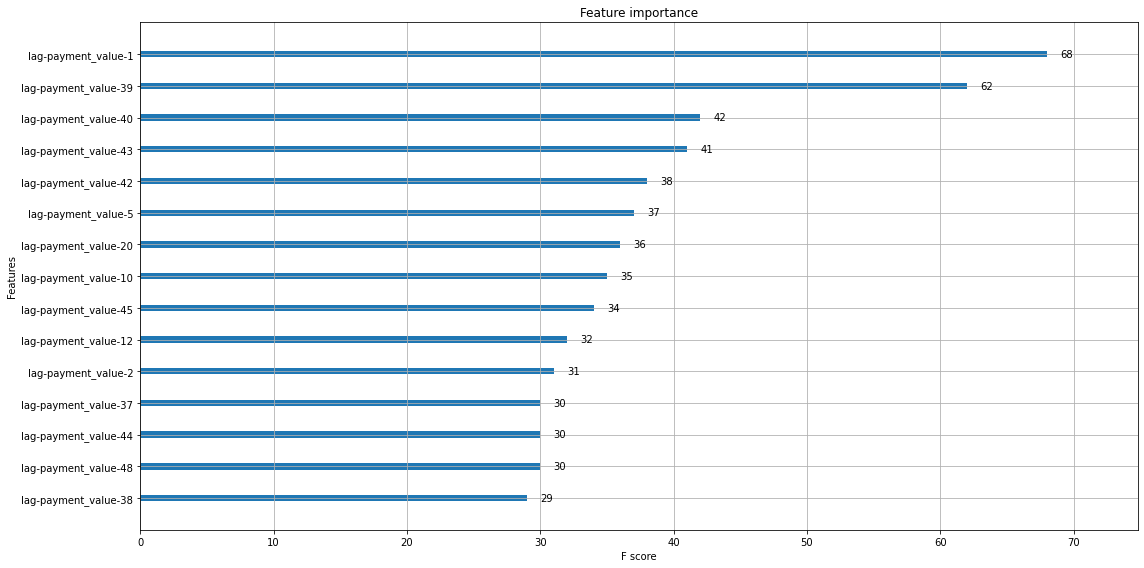

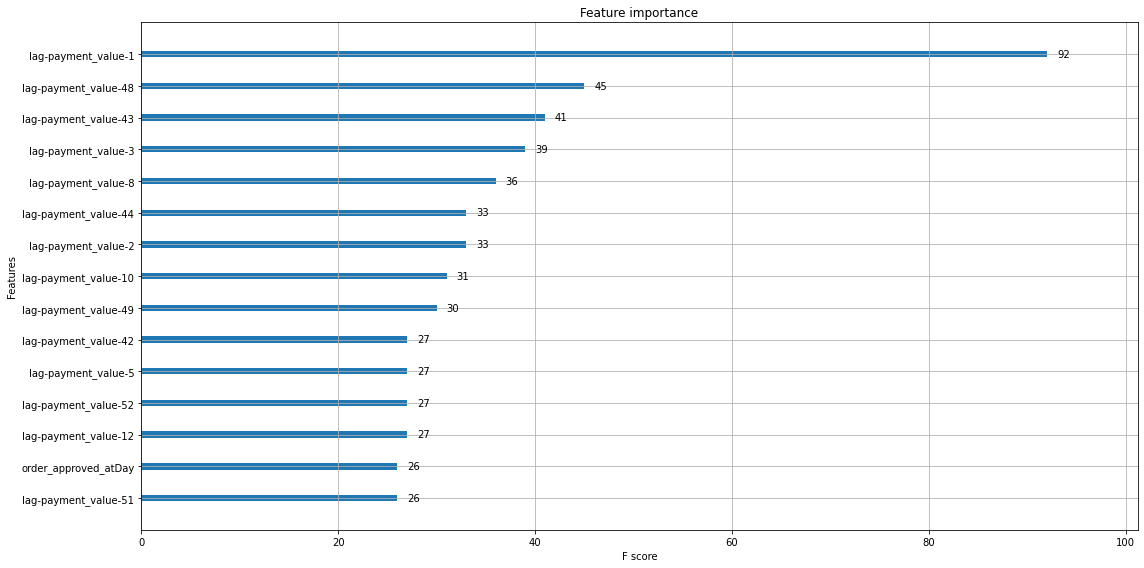

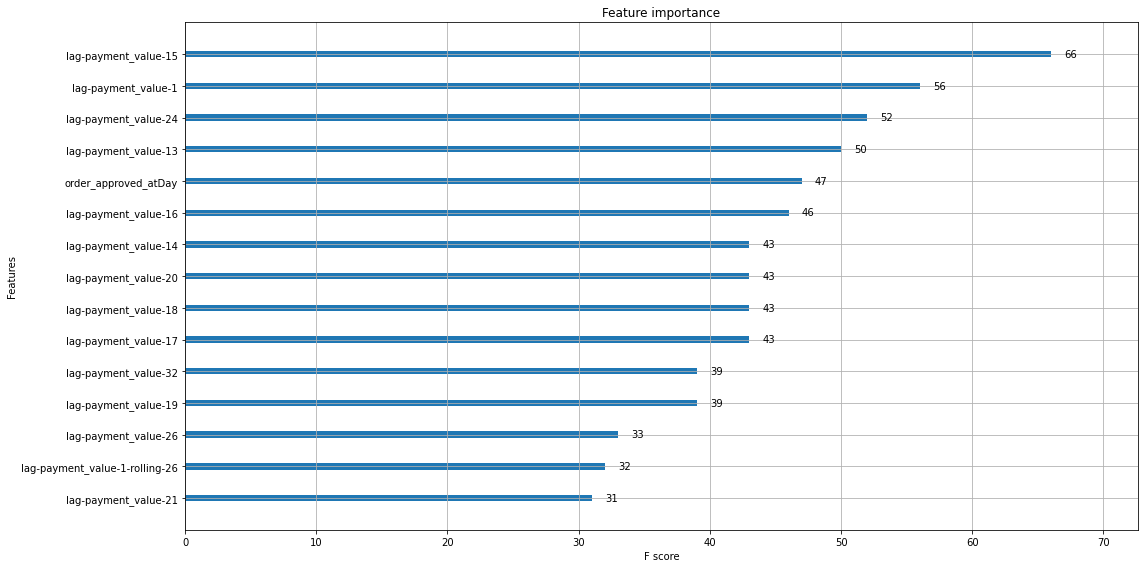

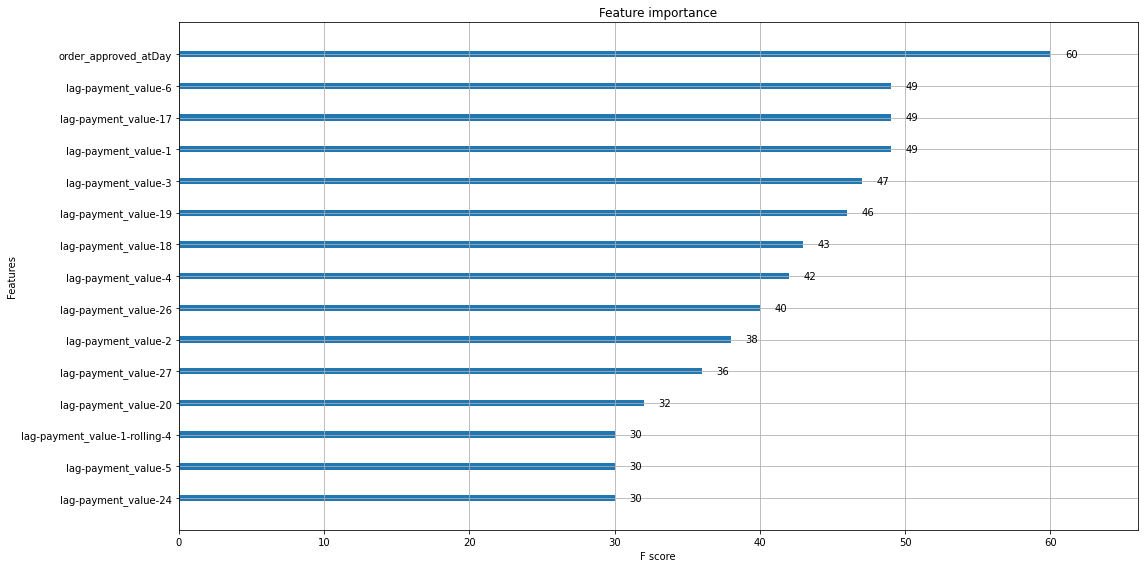

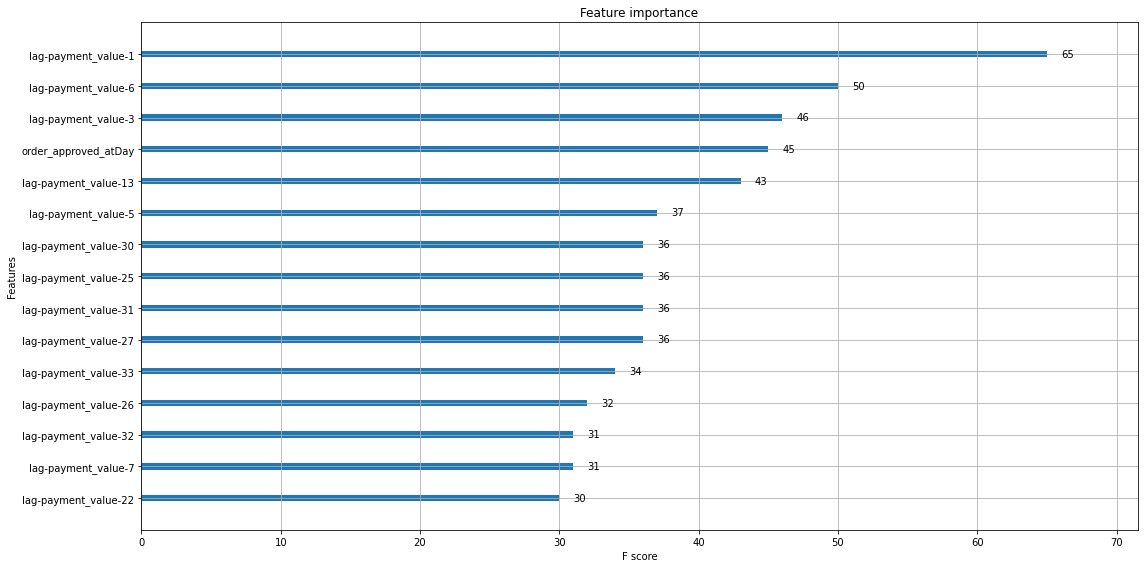

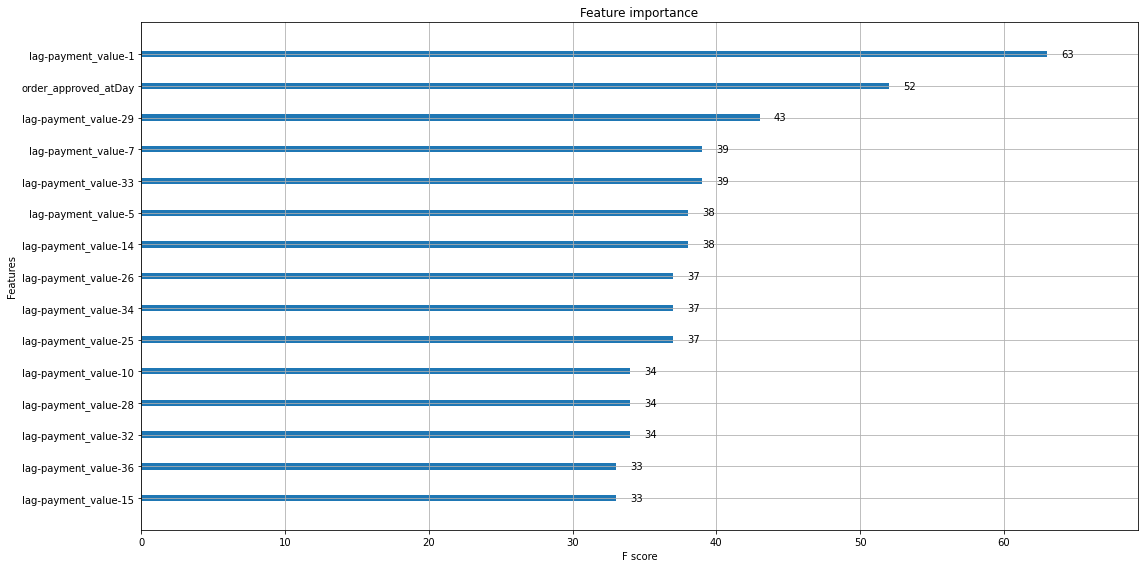

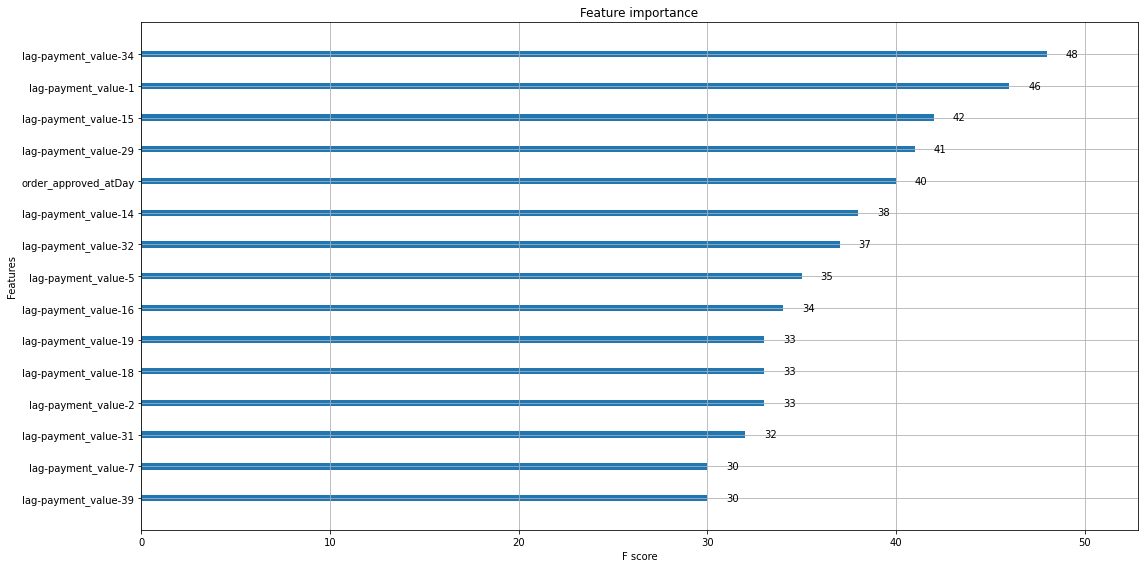

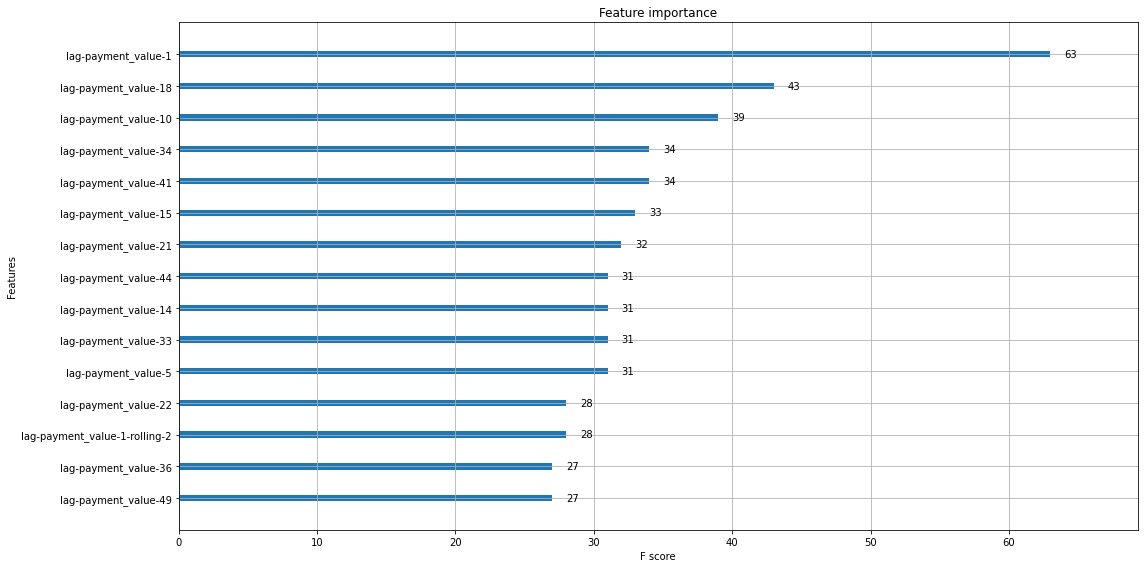

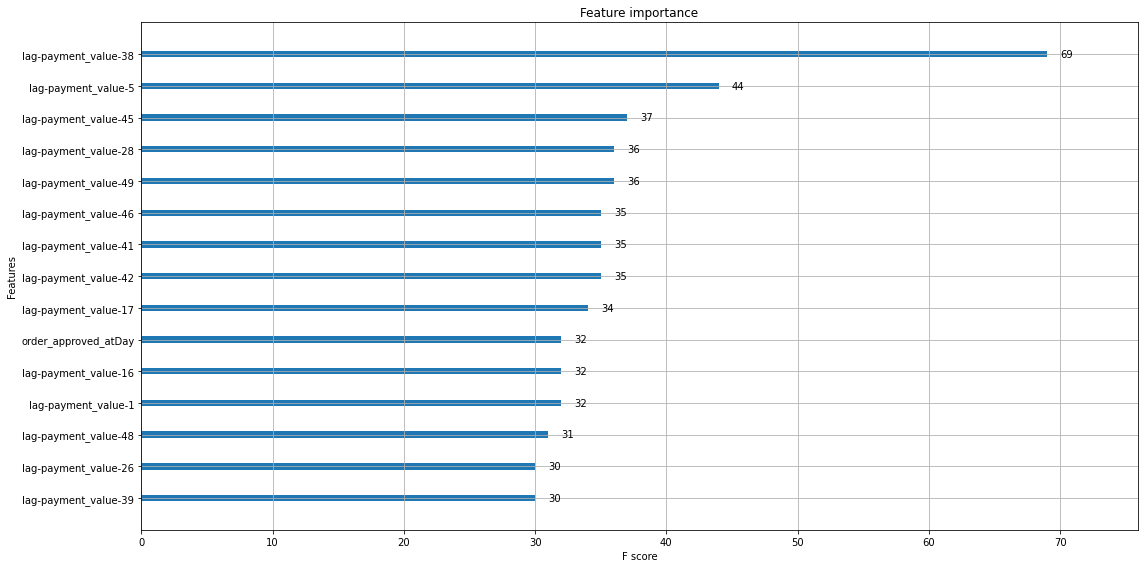

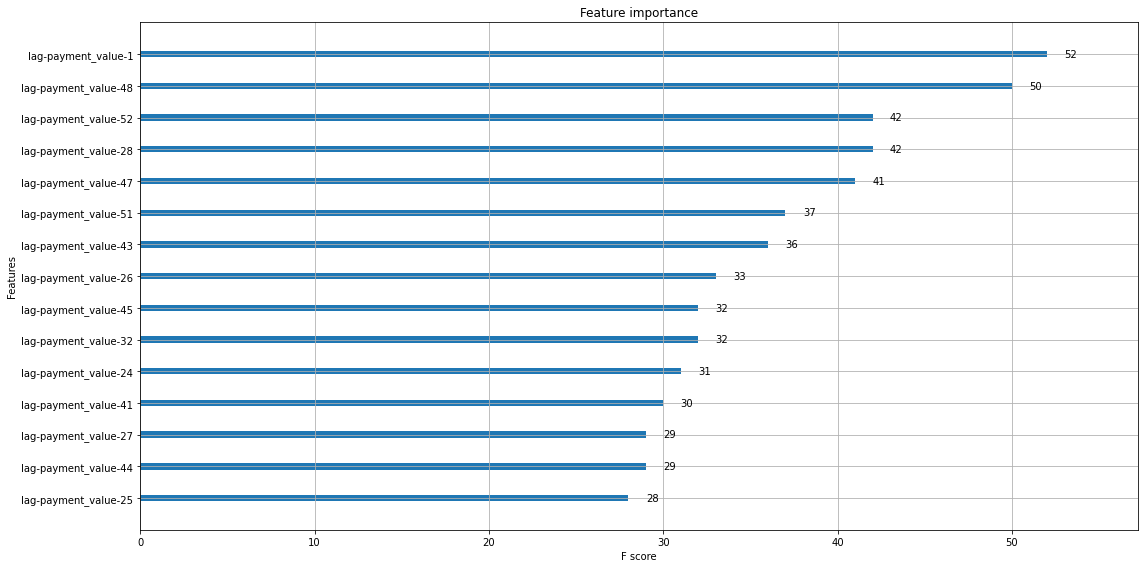

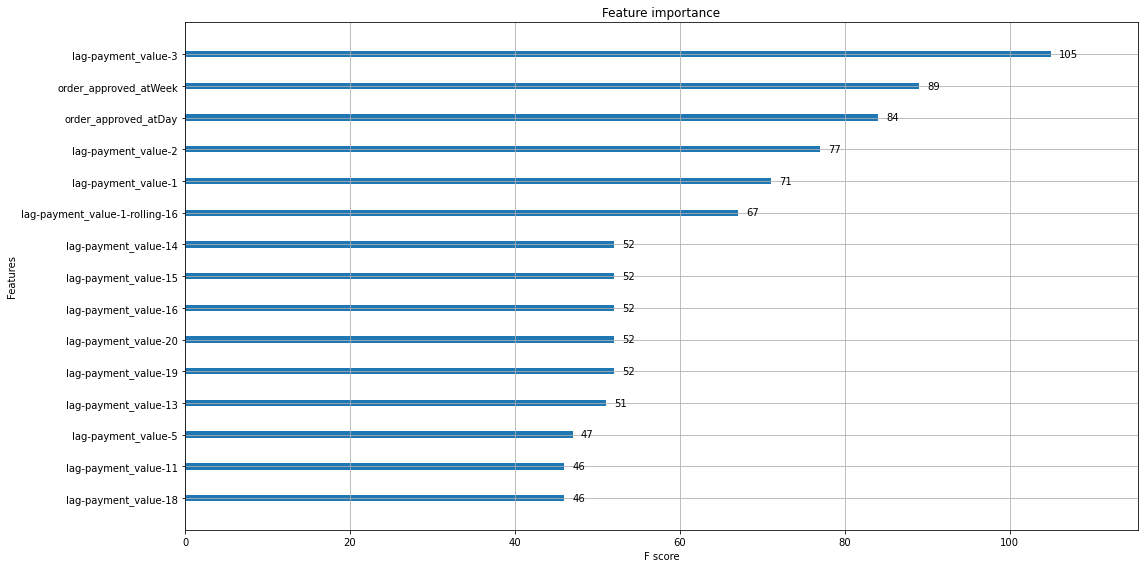

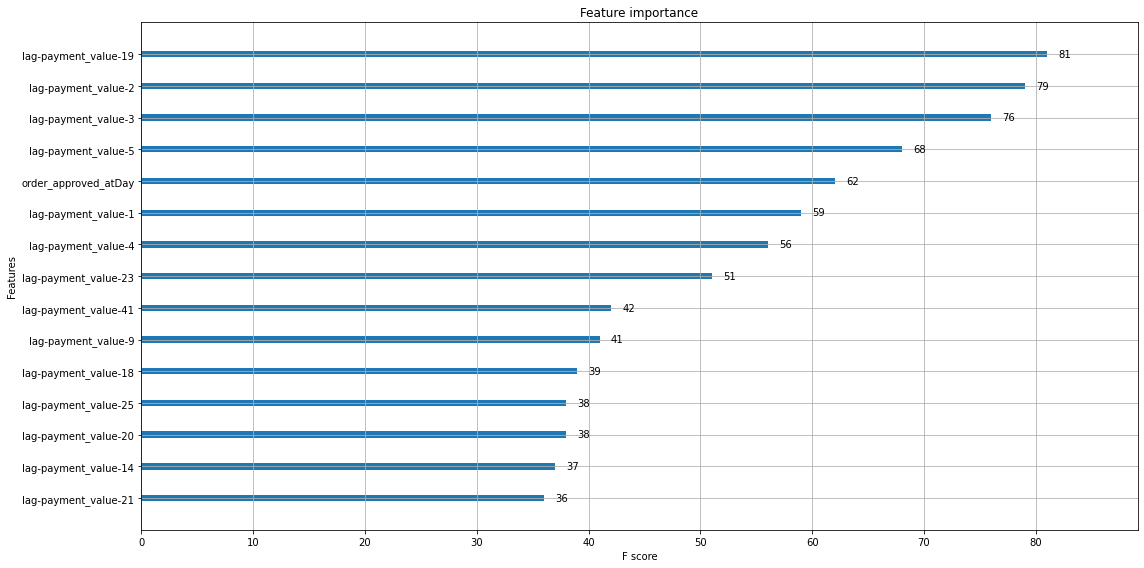

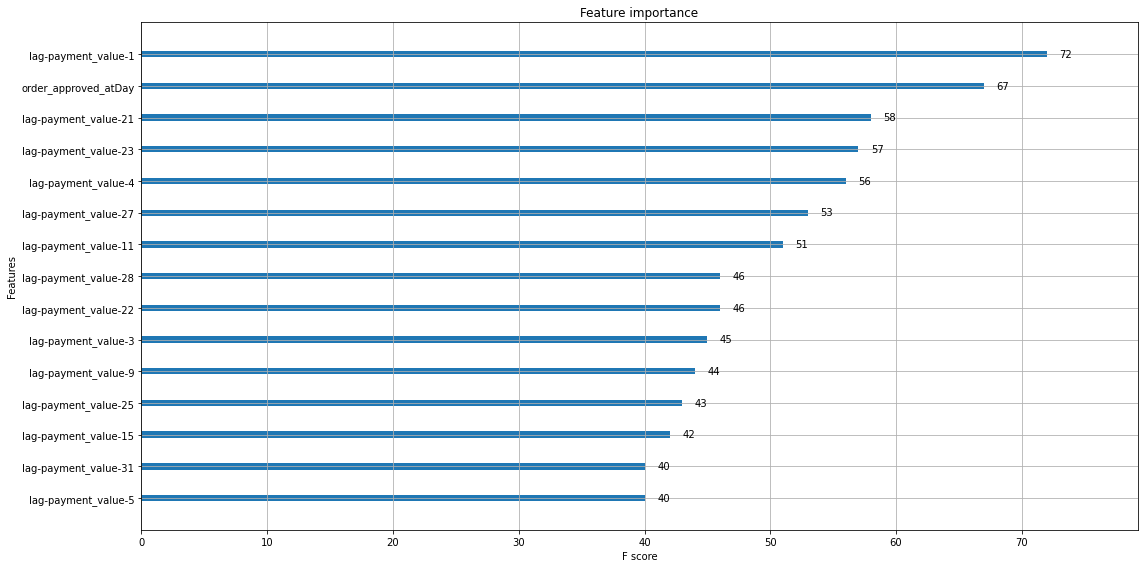

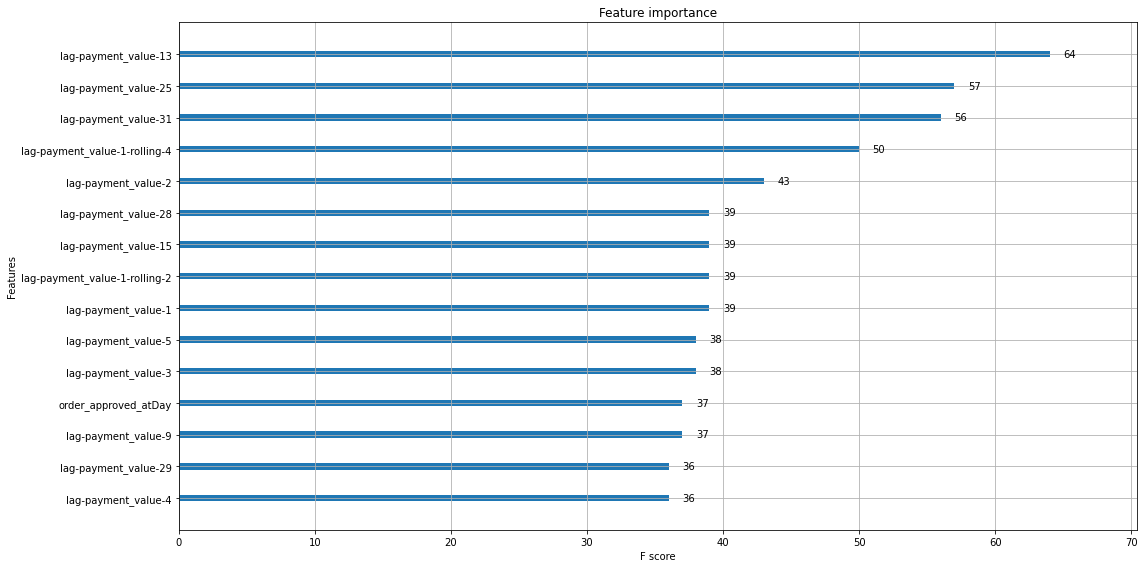

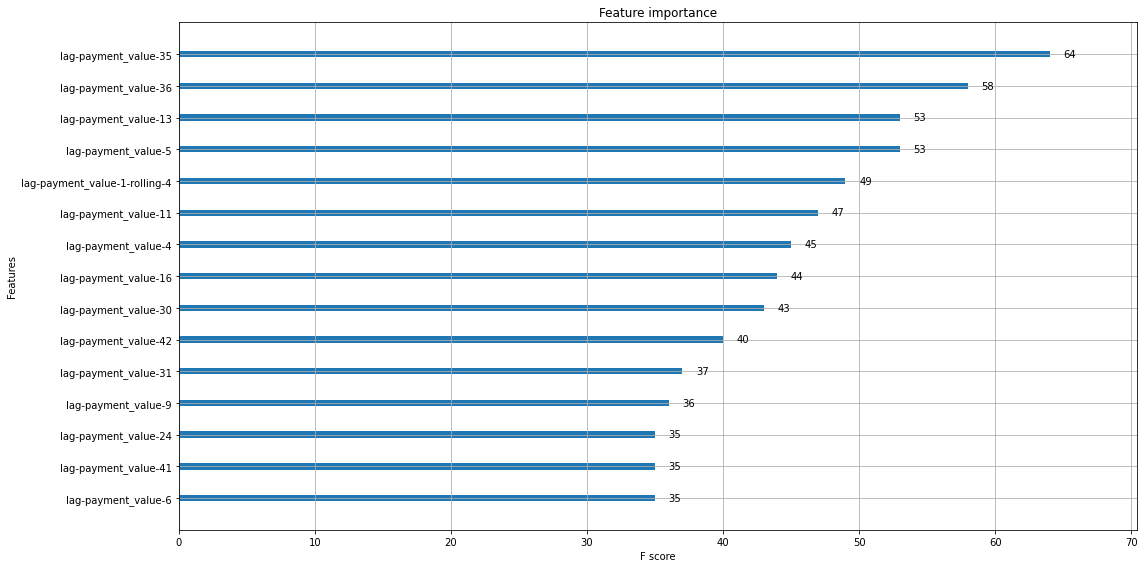

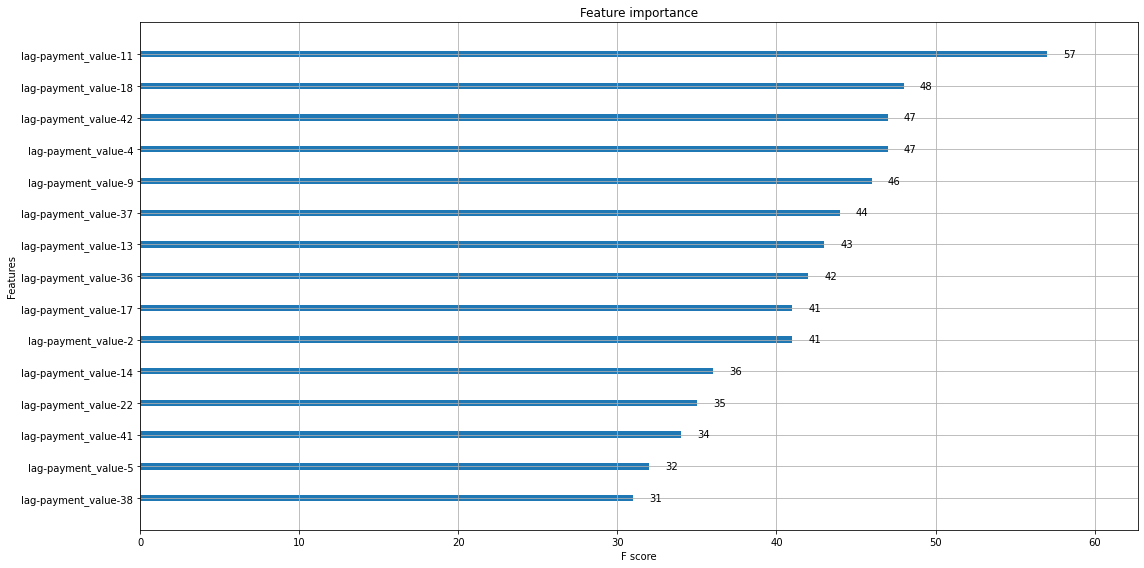

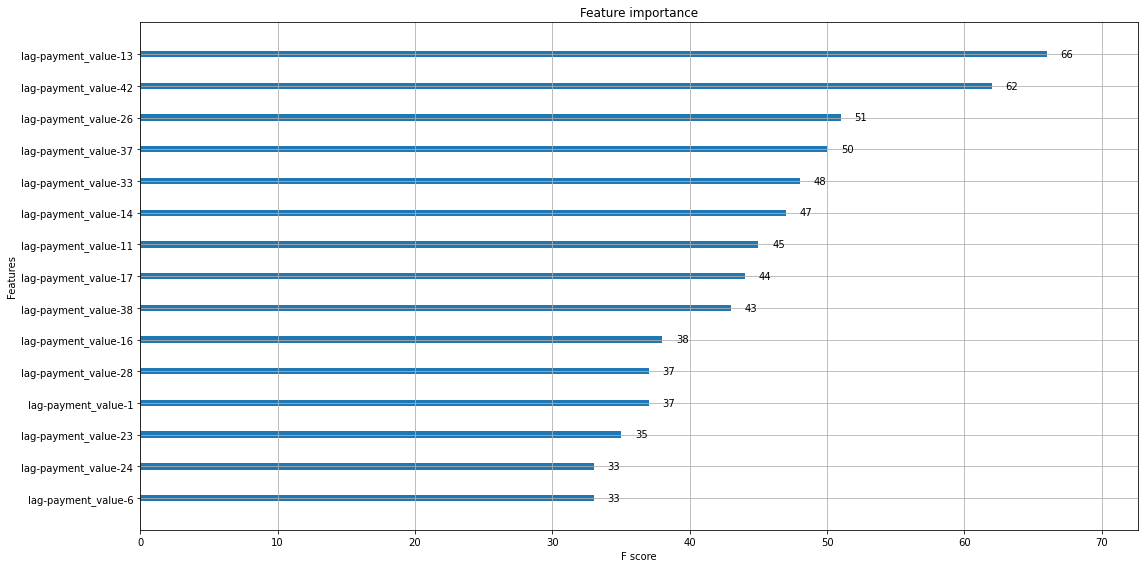

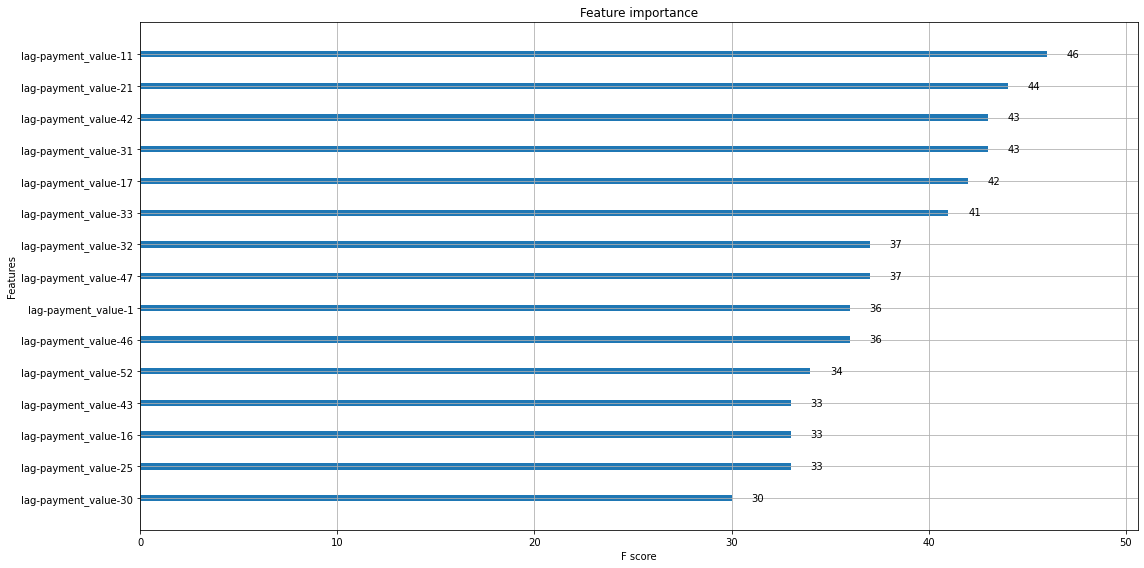

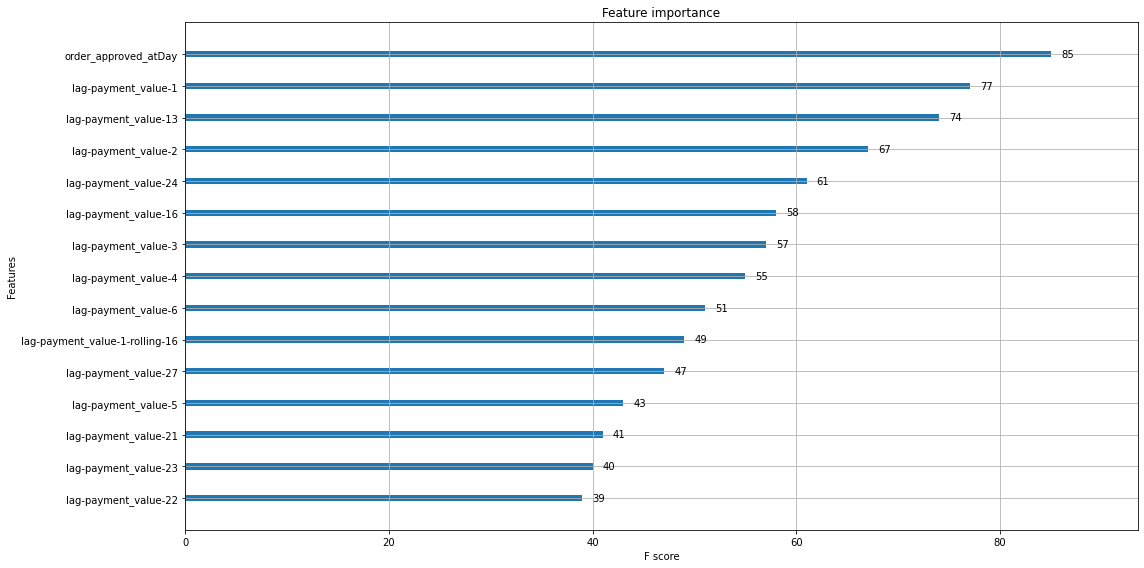

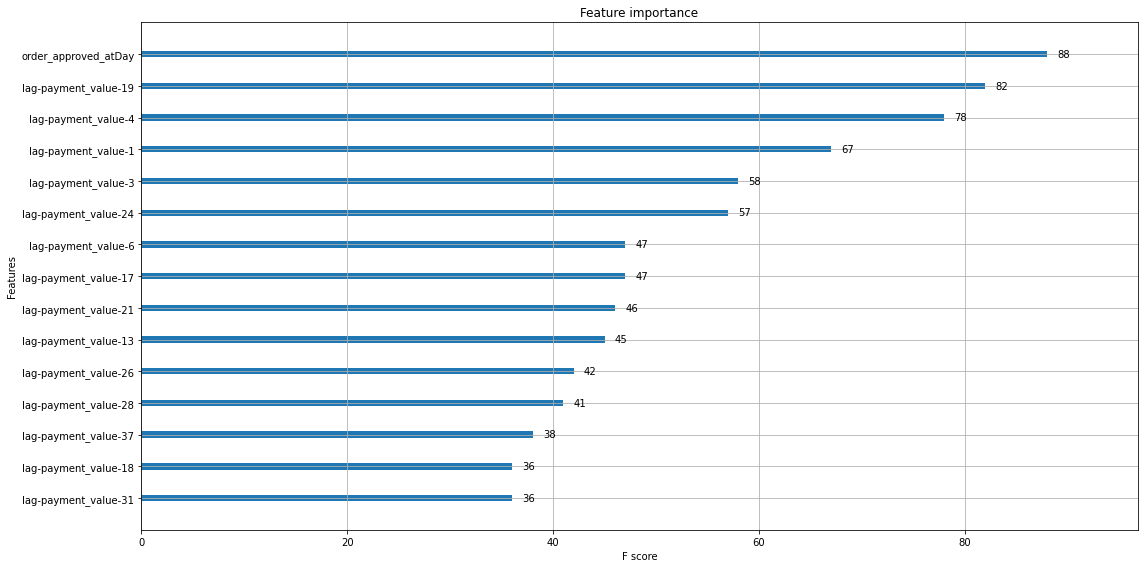

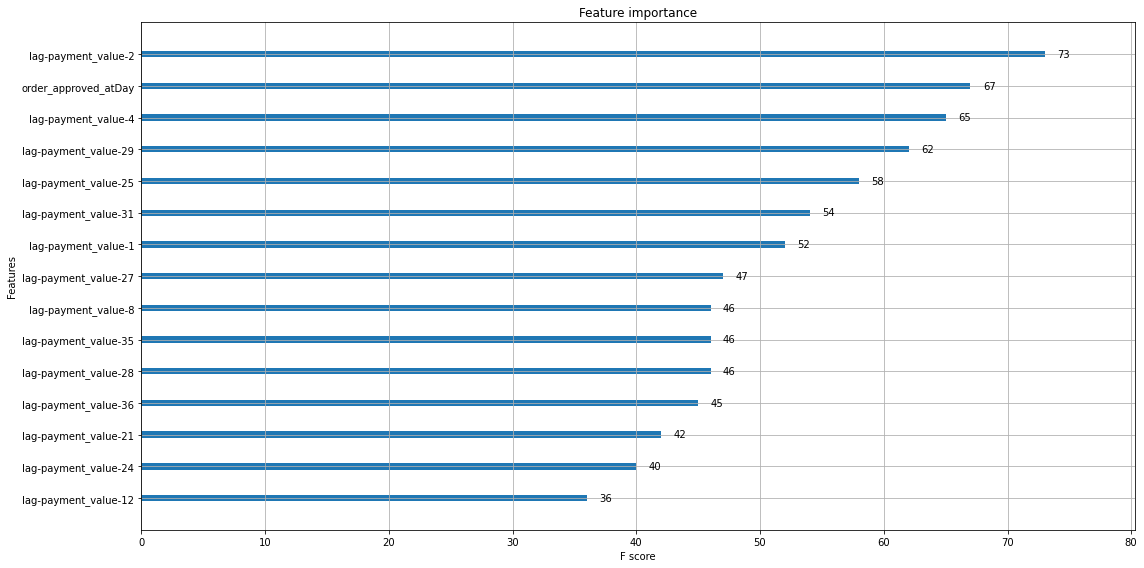

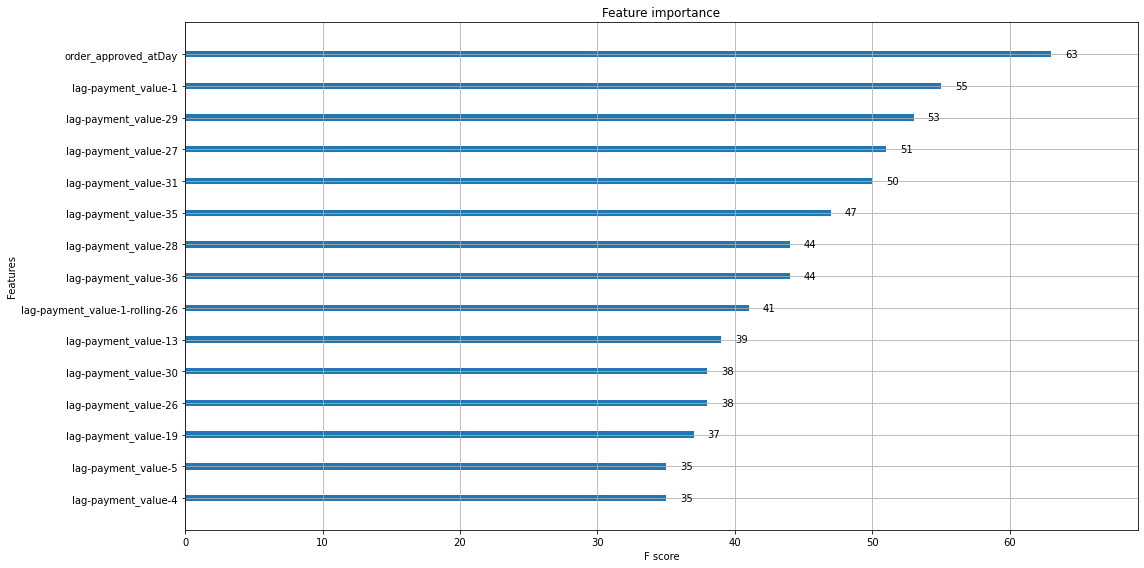

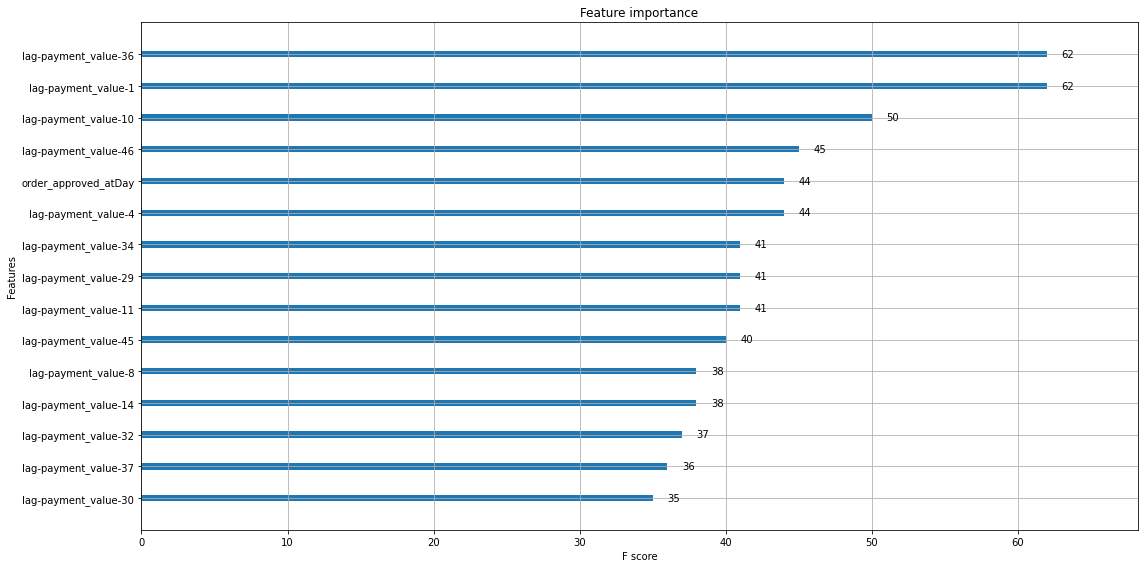

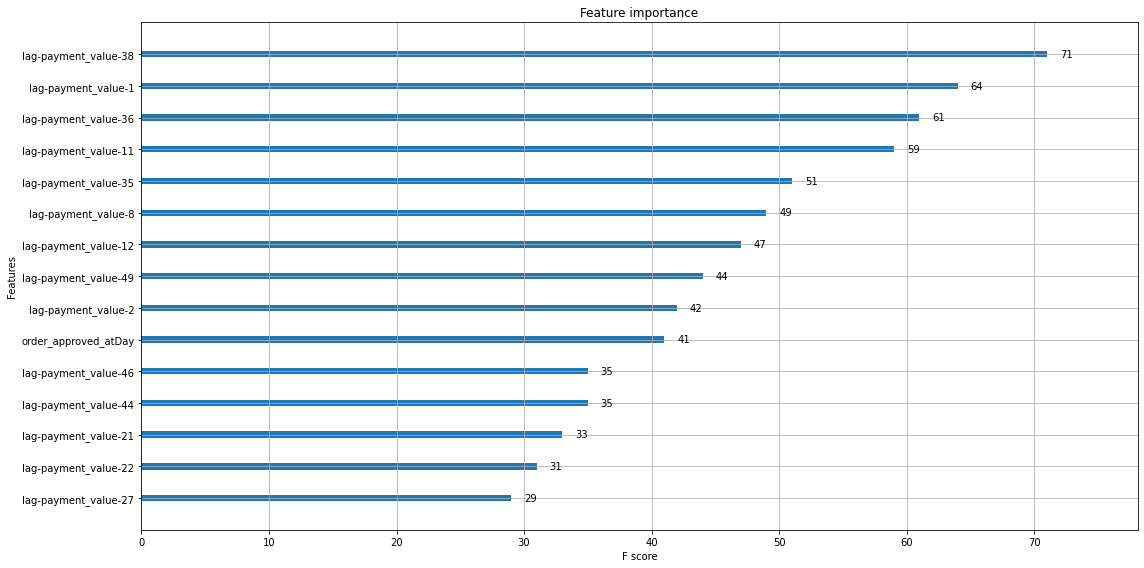

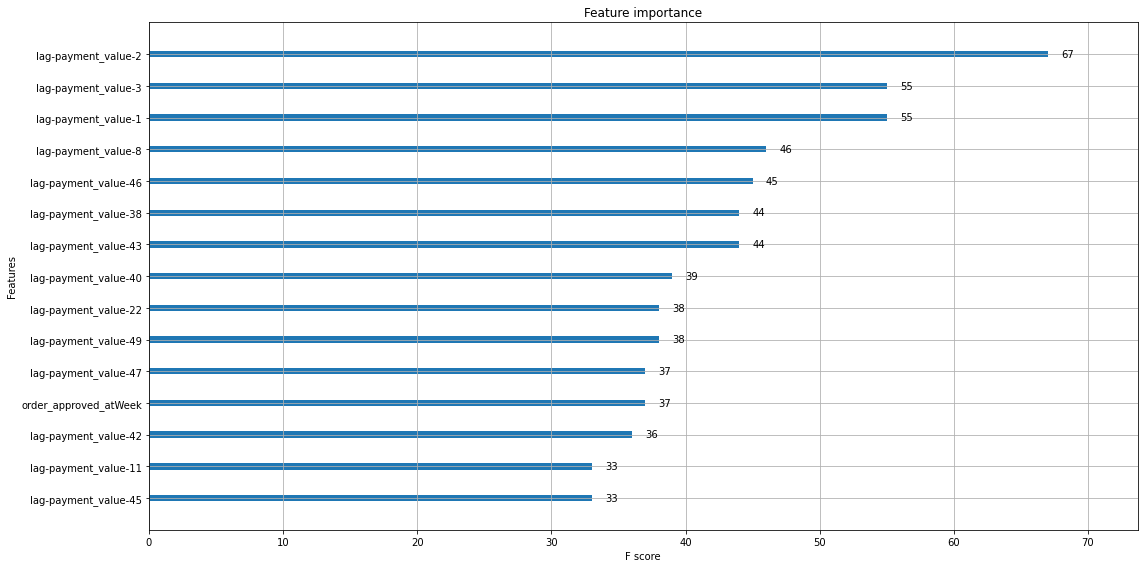

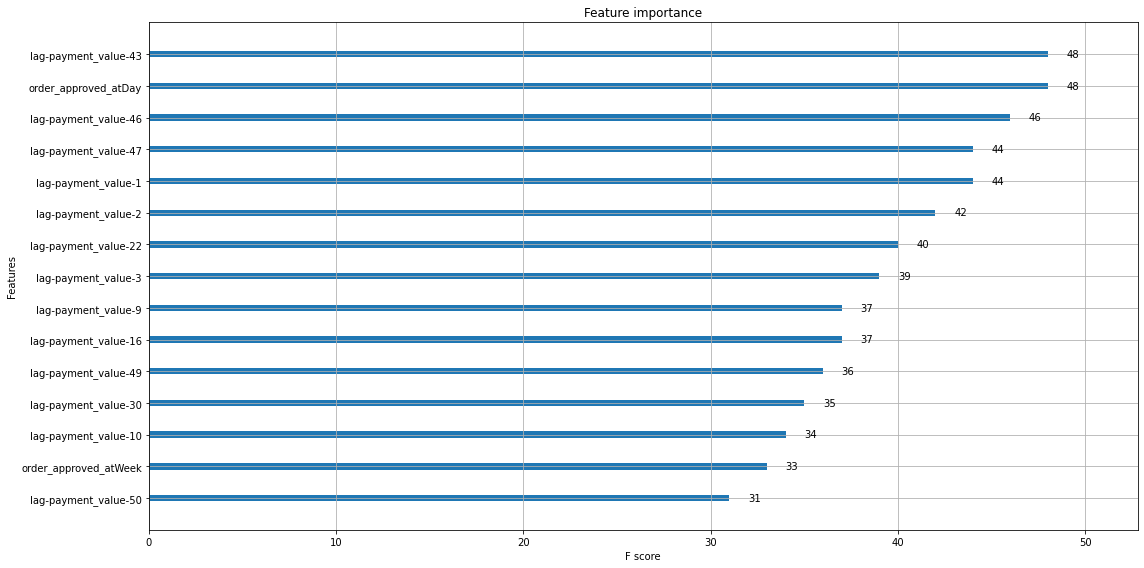

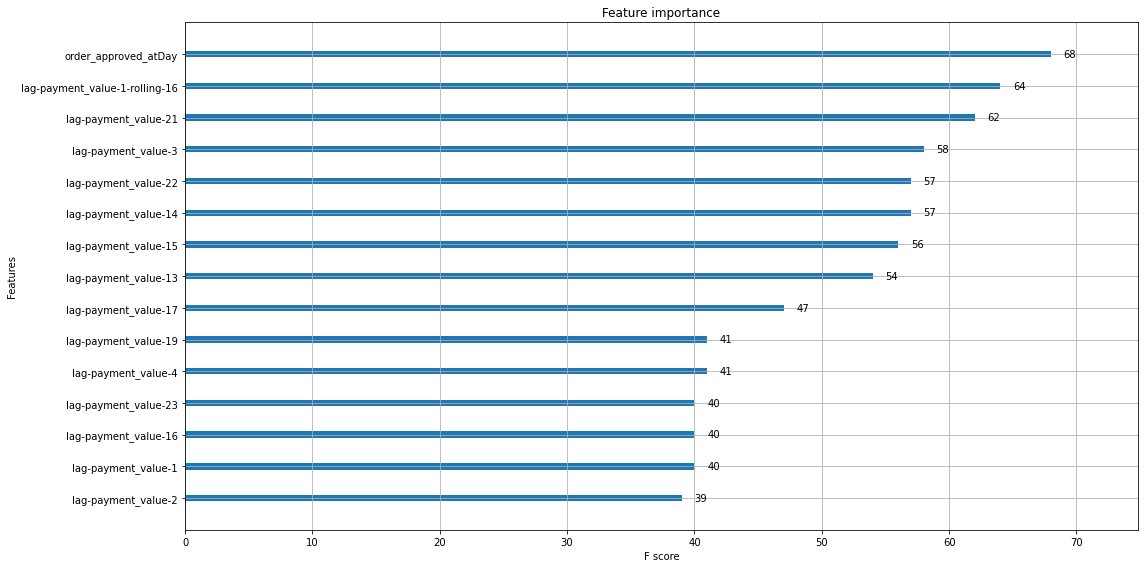

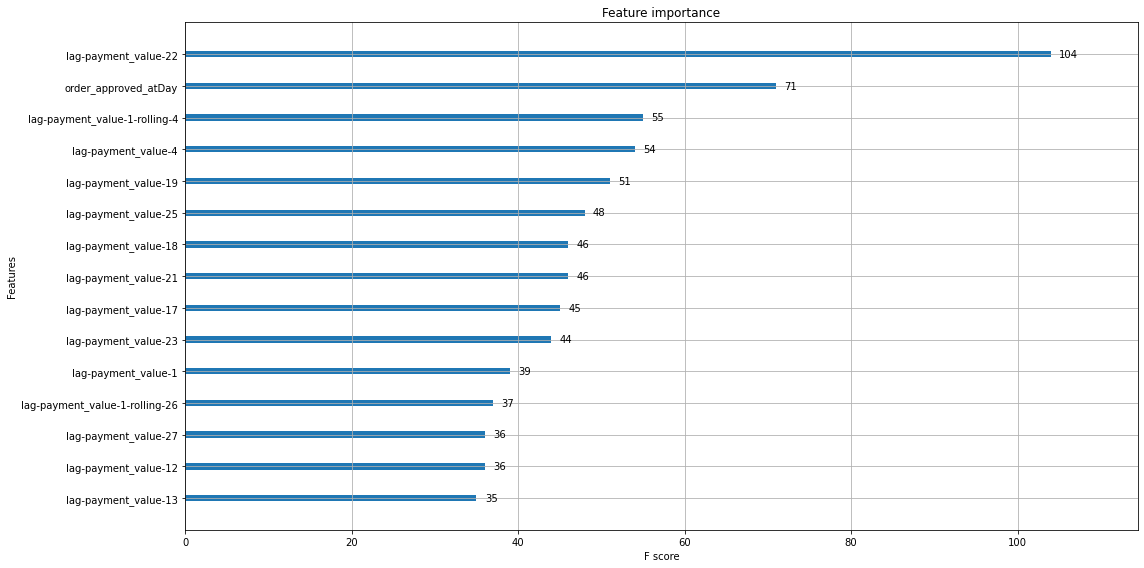

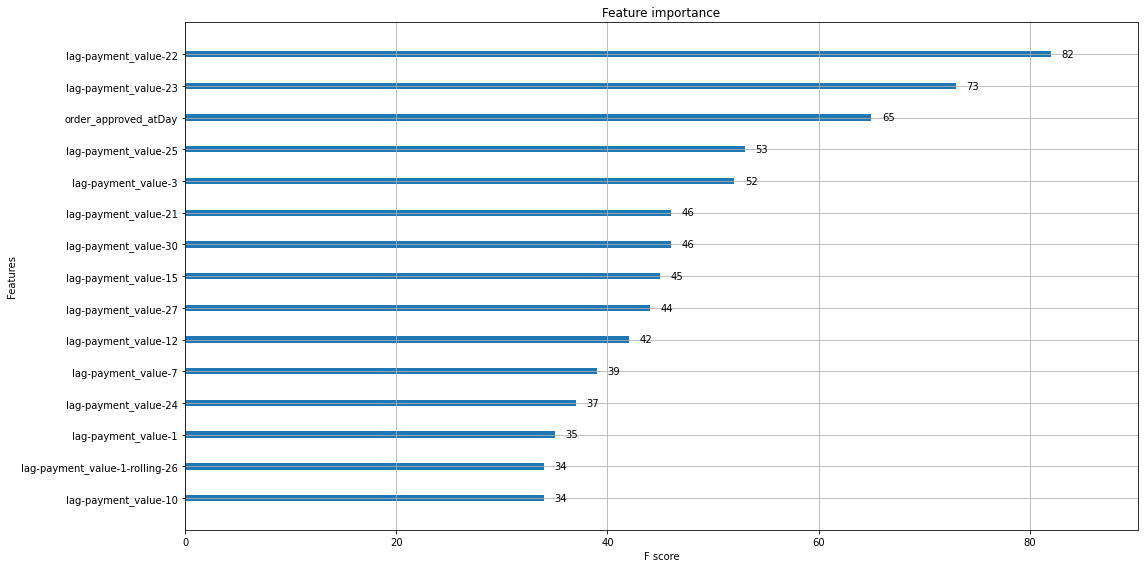

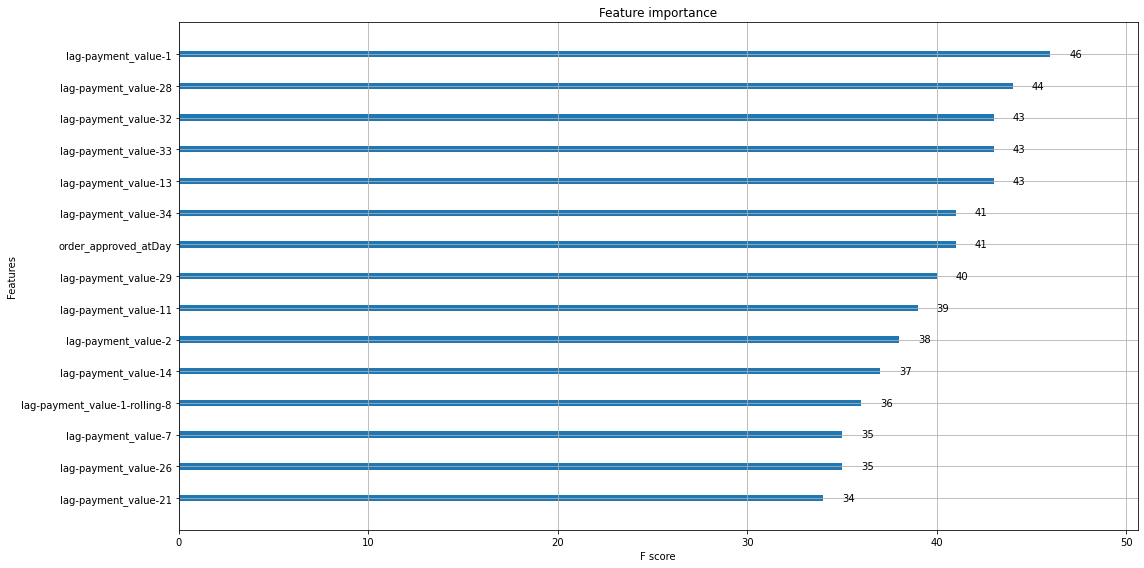

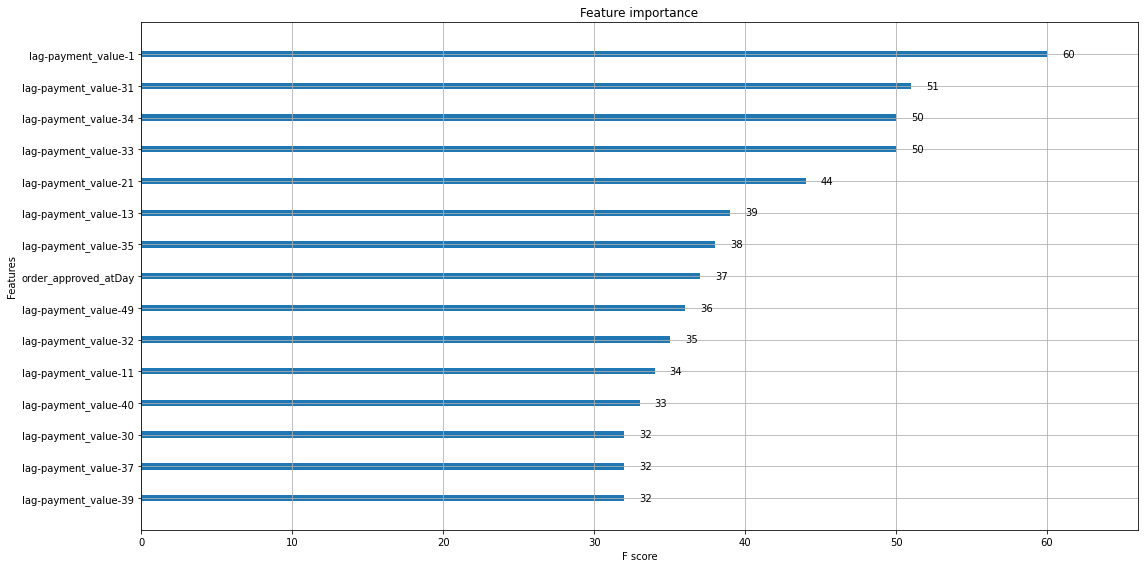

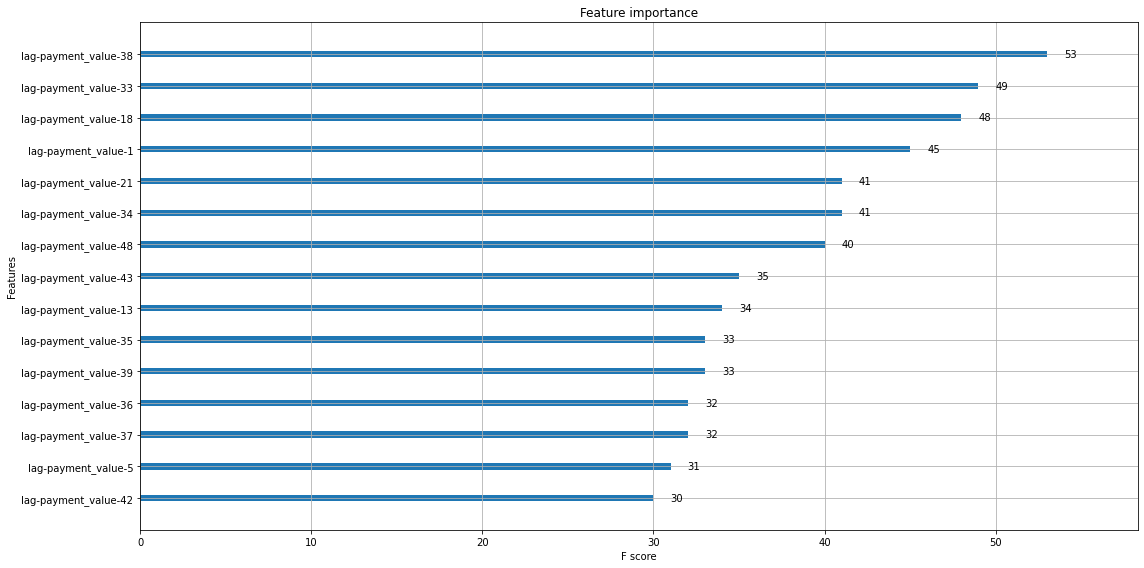

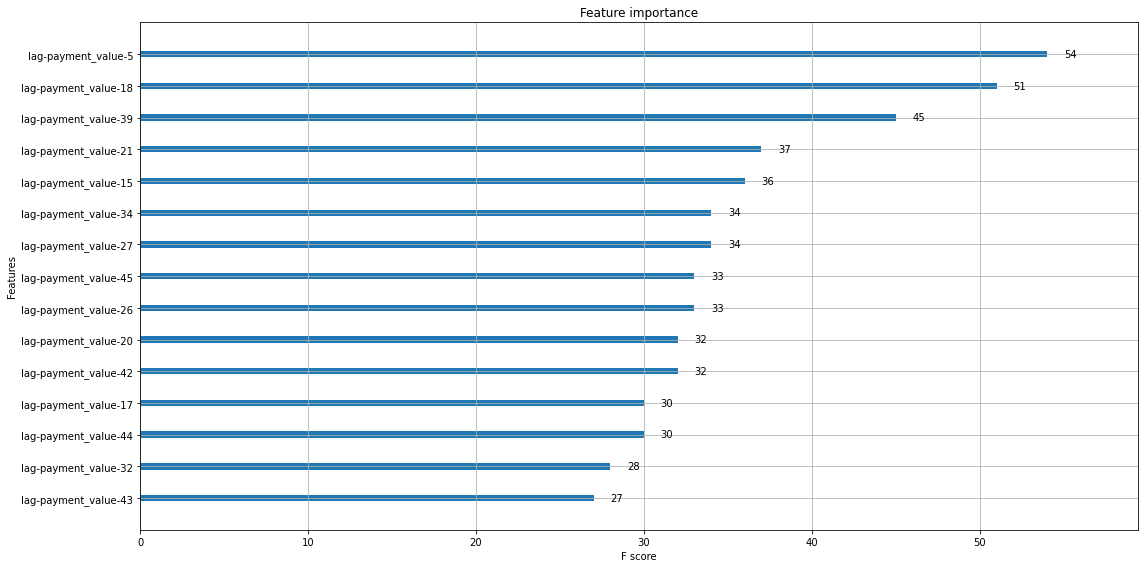

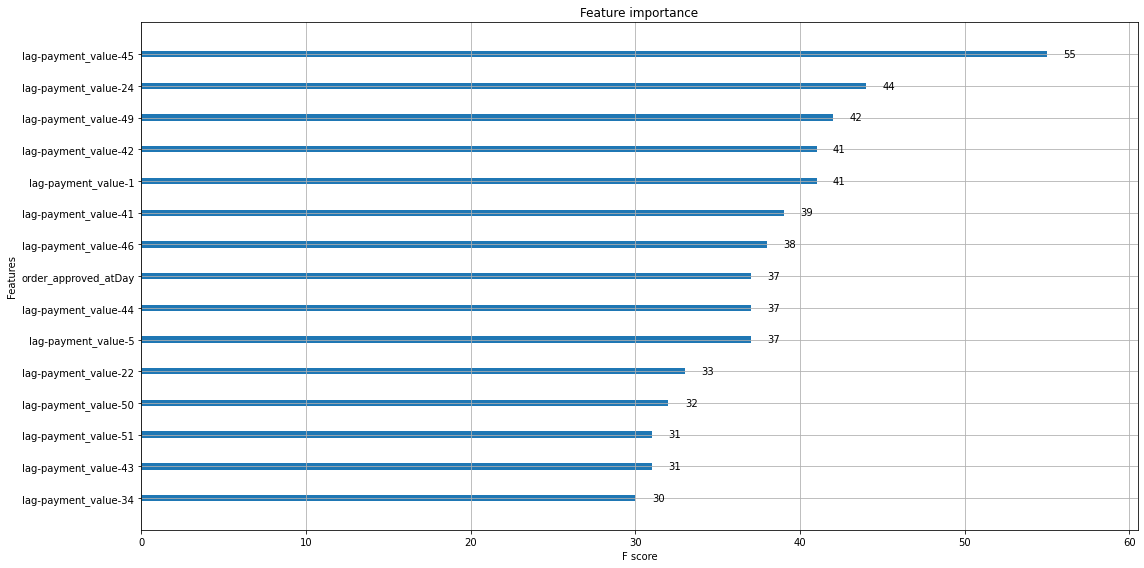

In [3]:
%%time

# Step 1: Read data and convert string to proper datetime objects
merged_data = pd.read_csv(os.path.join(proj_path, 
                                       catalog['output_dir']['dir'], 
                                       catalog['output_dir']['transactions']))

merged_data['order_approved_at'] = pd.to_datetime(merged_data['order_approved_at'])

# Step2: Create date folds
date_ranges = make_dates(params['olist']['experiment_dates'])


for prod_cat in params['olist']['product_categories']:
    print(f'Processing product category: {prod_cat}')
    
    # Initialize mlflow tracking
    create_folder(os.path.join(proj_path, 'mlruns'))
    #mlflow.set_tracking_uri(os.path.join(proj_path, 'mlruns'))
    mlflow.set_tracking_uri(os.path.join('../../','mlruns'))
    mlflow.set_experiment(prod_cat)
    
    start_timer = time()
    all_predictions = []
    all_hyperparameters = []
    # Iterate over each period, unpack tuple in each variable.
    # in each of the period, we will find the best set of parameters,
    # which will represent the time-series cross validation methodology
    for _, train_start, train_end, valid_start, valid_end, test_start, test_end in date_ranges.itertuples():
        print(f'  - - Processing range {str(train_start.date())} to {str(test_end.date())}')

        # allow the model to see past 6 months as features
        lag_units = params['xgb']['window_size']
        # different rolling averages as individual features
        avg_units = params['xgb']['avg_units']

        # Step x: First we filter out the stores and upcs, so that we obtain
        # a dataset that only considers the same product. Then we can do some feature engineering
        # which is required for xgboost. Because the initial features will result in NaNs,
        # we do it first, and then we filter them for respective dates. 
        filtered_data = merged_data[(merged_data['product_category_name']==prod_cat)][['payment_value','order_approved_at']].copy()

        # Add sale and date features (inplace)
        # We do this on all the data, to avoid having NaN at the begining due to calculating the lags
        make_lag_features(filtered_data, lag_units, col_name='payment_value', 
                          prefix_name='lag-payment_value', inplace=True)
        
        make_historical_avg(filtered_data, r_list=avg_units, col_n='lag-payment_value-1', google_trends=True)
        add_datepart(filtered_data, fldname='order_approved_at', drop=False)

        # Filter data
        training_df = filtered_data[(filtered_data['order_approved_at']>=train_start) &
                                    (filtered_data['order_approved_at']<=train_end)].copy()

        valid_df = filtered_data[(filtered_data['order_approved_at']>=valid_start) &
                                 (filtered_data['order_approved_at']<=valid_end)].copy()

        test_df = filtered_data[(filtered_data['order_approved_at']>=test_start) &
                                (filtered_data['order_approved_at']<=test_end)].copy()

        training_df.set_index('order_approved_at', inplace=True)
        valid_df.set_index('order_approved_at', inplace=True)
        test_df.set_index('order_approved_at', inplace=True)

        X_train = training_df
        y_train = X_train.pop('payment_value')
        X_valid = valid_df
        y_valid = X_valid.pop('payment_value')
        X_test = test_df
        y_test = X_test.pop('payment_value')

        #Function used to perform an evaluation on the validation set and return the score to the optimized function
        def _score(params):
            xg_boost_model = xgb.XGBRegressor(objective ='reg:squarederror',
                                              colsample_bytree = params['colsample_bytree'],
                                              learning_rate = params['eta'],
                                              max_depth = params['max_depth'],
                                              min_child_weight = params['min_child_weight'],
                                              n_estimators = params['n_estimators'],
                                              random_state = 2020,
                                              subsample = params['subsample'],
                                              tree_method = 'hist')
            xg_boost_model.fit(X_train, y_train)
            preds = xg_boost_model.predict(X_valid)
            mape = mean_absolute_percentage_error(y_valid, preds)
            
            return mape
        
        trials = Trials()
        best_hyperparams = optimize()
        hyperparams = space_eval(space, best_hyperparams)

        all_hyperparameters.extend(hyperparams)
        xgb_model = XGBClassifier(hyperparams)
        
        # Concat training with validation data
        xgb_model.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))

        test_preds = xgb_model.predict(X_test)
        all_predictions.extend(test_preds)
        
        # Save plot importance for specific fold
        rcParams.update({'figure.autolayout': True}) # for saving in correct size
        fig, ax = plt.subplots(figsize=(16, 8))
        xgb.plot_importance(xgb_model, max_num_features=15, ax=ax)
        plot_dir = proj_path / catalog['extra']['dir'] / catalog['extra']['xgb_importance'] / f'{str(test_end.date())}'
        plot_name = plot_dir / f'olist_xgb_exp1_{prod_cat}.png'
        create_folder(plot_dir)      
        plt.savefig(plot_name)

    df_filtered = merged_data[(merged_data['product_category_name'] == prod_cat) &
                              (merged_data['order_approved_at'] >= params['olist']['experiment_dates']['test_start']) & 
                              (merged_data['order_approved_at'] <= params['olist']['experiment_dates']['test_end'])].copy()
    
    test_metrics = get_metrics(df_filtered['payment_value'].values, all_predictions)
    
    save_data = pd.DataFrame({'y_true': df_filtered['payment_value'],
                              'preds': all_predictions,
                              'dates': df_filtered['order_approved_at']})
    
    fdir = os.path.join(proj_path, catalog['results']['dir'])
    fname = os.path.join(fdir, f'xgb_exp1_{prod_cat}.csv')
    create_folder(fdir)
    save_data.to_csv(fname)
            
    fdir_hparam = os.path.join(proj_path, catalog['extra']['dir'], catalog['extra']['xgb_hyperparams'])
    fname_hparam = os.path.join(fdir_hparam, f'xgb_exp1_{prod_cat}.csv')
    create_folder(fdir_hparam)
    
    with open(fname_hparam, "wb") as filehandler:
        pickle.dump(all_hyperparameters, filehandler)
    duration_min = int((time() - start_timer) // 60)
    
    with mlflow.start_run():
        mlflow.log_artifact(fname)
        mlflow.log_artifact(fname_hparam)
        mlflow.log_param('model','xgb')
        mlflow.log_metric('time', duration_min)
        mlflow.log_param('add_date', 'true')
        mlflow.log_params(params['xgb'])
        mlflow.log_metrics(test_metrics)
    